# Pressure Gradient Shape Analysis

Using PPM (piecewise polynomial, can replicate quadratic functions) construction in the vertical

Quadratic and exponential stratification, linear eqn of state? 

python-ified MOM6 analytic finite volume pressure gradient formulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from matplotlib import pyplot


In [2]:
# from subroutine PressureForce_FV_Bouss(h, tv, PFu, PFv, G, GV, US, CS, ALE_CSp, p_atm, pbce, eta)
# in MOM_PressureForce_FV.F90

#call TS_PLM_edge_values(ALE_CSp, S_t, S_b, T_t, T_b, G, GV, tv, h, CS%boundary_extrap)

# call int_density_dz_generic_plm(k, tv, T_t, T_b, S_t, S_b, e, &
#                     rho_ref, CS%Rho0, GV%g_Earth, dz_neglect, G%bathyT, &
#                     G%HI, GV, tv%eqn_of_state, US, CS%use_stanley_pgf, dpa, intz_dpa, intx_dpa, inty_dpa, &
#                     useMassWghtInterp=CS%useMassWghtInterp, &
#                     use_inaccurate_form=CS%use_inaccurate_pgf_rho_anom, Z_0p=G%Z_ref)

# PFu(I,j,k) = (((pa(i,j)*h(i,j,k) + intz_dpa(i,j)) - &
#            (pa(i+1,j)*h(i+1,j,k) + intz_dpa(i+1,j))) + &
#            ((h(i+1,j,k) - h(i,j,k)) * intx_pa(I,j) - &
#            (e(i+1,j,K+1) - e(i,j,K+1)) * intx_dpa(I,j) * GV%Z_to_H)) * &
#            ((2.0*I_Rho0*G%IdxCu(I,j)) / &
#            ((h(i,j,k) + h(i+1,j,k)) + h_neglect))

# from subroutine int_density_dz_generic_plm(k, tv, T_t, T_b, S_t, S_b, e, rho_ref, &
#                                       rho_0, G_e, dz_subroundoff, bathyT, HI, GV, EOS, US, use_stanley_eos, dpa, &
#                                       intz_dpa, intx_dpa, inty_dpa, useMassWghtInterp, &
#                                       use_inaccurate_form, Z_0p)
# in MOM_density_integrals.F90

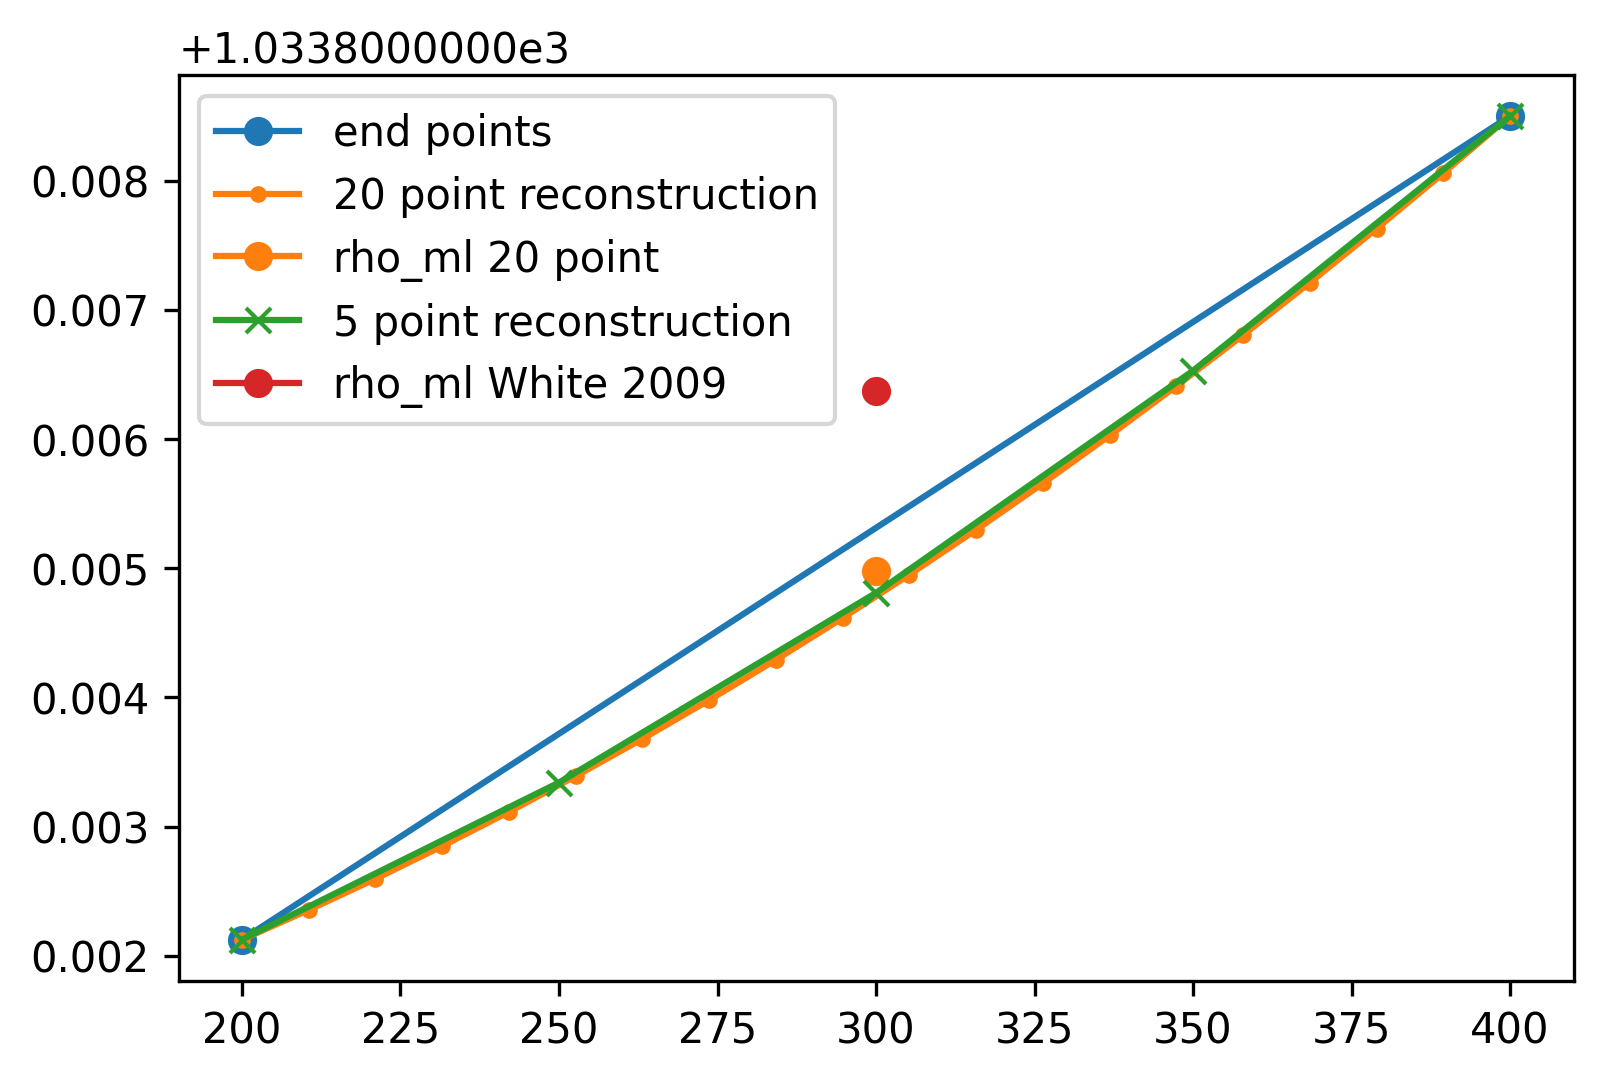

In [3]:
# check ppm reconstruction

z_bot = 4000
strat = 0.85;rhoref = 1035;rhotop=1000+33.8*1;S2=2

z_tl = 200
z_bl = 400

rho_tl = rhotop+(z_tl/z_bot)**S2*strat
rho_bl = rhotop+(z_bl/z_bot)**S2*strat
#average of top and bottom
rho_ml = (rho_tl + rho_bl)/2 #rhotop+((z_bl+z_tl)/2/z_bot)**S2*strat

#alternative from White et al 2009
#u_0 = 1/3*(u_L + 2*u_R -0.5*du_dxR )
#print(rho_tl,rho_ml,rho_bl)
rho_ml_W = 1/3*(1*rho_tl + 2*rho_bl - 0.5*(strat*S2*(z_bl/z_bot)**(S2-1)/z_bot))
#rho_ml_W = 1/3*(rho_tl + 2*rho_bl - 0.5*(rho_bl-rho_tl)/(z_bl-z_tl))

#print(rho_tl,rho_ml,rho_bl)

#average from np arange
rhos_l = np.linspace(z_tl,z_bl,20)
rho_ml = np.mean(rhotop+(rhos_l/z_bot)**S2*strat)
#print(rho_tl,rho_ml,rho_bl)

# 1. compute vertical integrals
# PPM: first determine curvature of parabolas
r6l = 3*(2*rho_ml-(rho_bl+rho_tl)) # DOES NOT RECREATE PARABOLIC DENSITY PROFILE!! using 2 does

# first sample density in column by 5 points
wt_t = 1-0.25*np.arange(5) #weighting for each pt for top density
wt_b = 1-wt_t #weighting for each pt for bottom density

r5l = wt_t * rho_tl + wt_b * (rho_bl + r6l*wt_t) -rhoref # accounts for parabola curvature

fig,axes = plt.subplots(dpi = 300)
plt.plot([z_tl,z_bl],[rho_tl,rho_bl], label = 'end points',marker = 'o')
plt.plot(rhos_l,rhotop+(rhos_l/z_bot)**S2*strat, marker = '.',label = '20 point reconstruction')
plt.plot([(z_tl+z_bl)/2],[rho_ml],marker = 'o', color = 'C1', label = 'rho_ml 20 point')
plt.plot(wt_b*(z_bl-z_tl)+z_tl,r5l+rhoref, marker = 'x',label = '5 point reconstruction')
plt.plot([(z_tl+z_bl)/2],[rho_ml_W],marker = 'o',  label = 'rho_ml White 2009')

plt.legend()

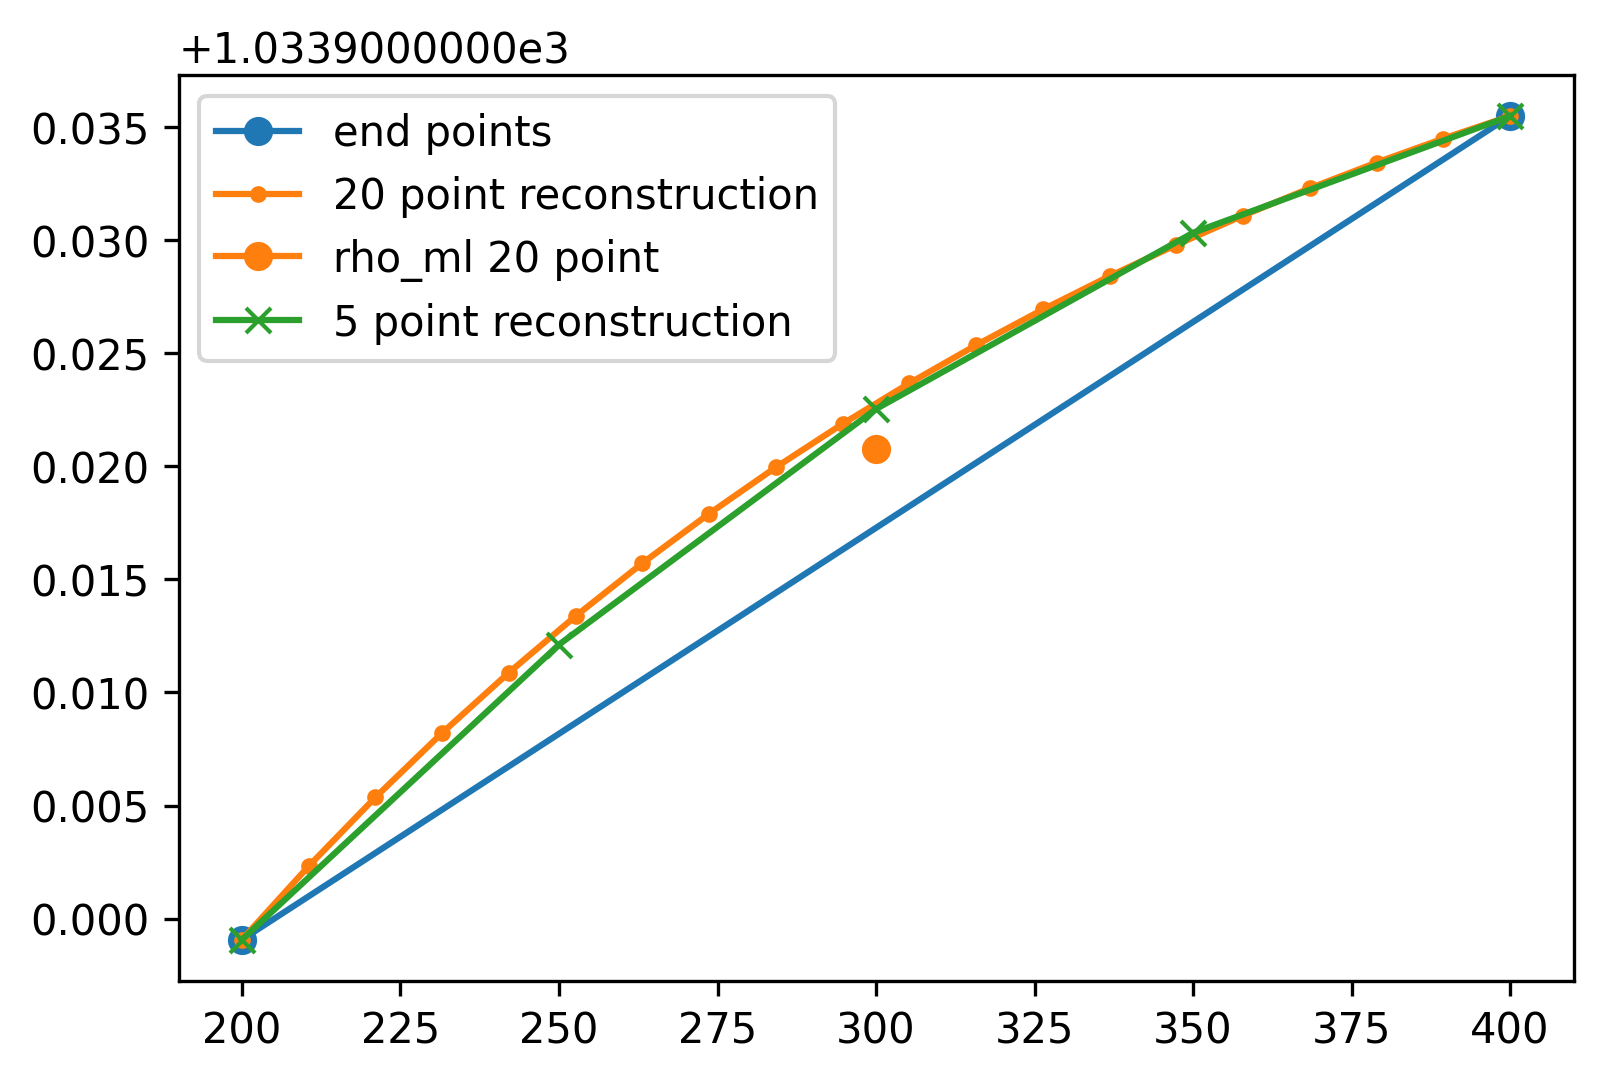

In [4]:
# check ppm reconstruction exp

z_bot = 4000
rhoref = 1035;
rhotop=1033.772
strat=-0.1781
z_tl = 200
z_bl = 400
S2=25

rho_tl = rhotop+strat*(np.exp(-z_tl/z_bot*S2)-1)
rho_bl = rhotop+strat*(np.exp(-z_bl/z_bot*S2)-1)
rho_ml = (rho_tl + rho_bl)/2 #rhotop+((z_bl+z_tl)/2/z_bot)**S2*strat
#average from np arange
rhos_l = np.linspace(z_tl,z_bl,20)
rho_ml = np.mean(rhotop+strat*(np.exp(-rhos_l/z_bot*S2)-1))

# 1. compute vertical integrals
# PPM: first determine curvature of parabolas
r6l = 3*(2*rho_ml-(rho_bl+rho_tl)) # DOES NOT RECREATE PARABOLIC DENSITY PROFILE!! using 2 does

# first sample density in column by 5 points
wt_t = 1-0.25*np.arange(5) #weighting for each pt for top density
wt_b = 1-wt_t #weighting for each pt for bottom density

r5l = wt_t * rho_tl + wt_b * (rho_bl + r6l*wt_t) -rhoref # accounts for parabola curvature

fig,axes = plt.subplots(dpi = 300)
plt.plot([z_tl,z_bl],[rho_tl,rho_bl], label = 'end points',marker = 'o')
plt.plot(rhos_l,rhotop+strat*(np.exp(-rhos_l/z_bot*S2)-1), marker = '.',label = '20 point reconstruction')
plt.plot([(z_tl+z_bl)/2],[rho_ml],marker = 'o', color = 'C1', label = 'rho_ml 20 point')
plt.plot(wt_b*(z_bl-z_tl)+z_tl,r5l+rhoref, marker = 'x',label = '5 point reconstruction')
#plt.plot([(z_tl+z_bl)/2],[rho_ml_W],marker = 'o',  label = 'rho_ml White 2009')

plt.legend()

In [5]:
def pg_given_rhos_mwipg_5pt_ppm(z_tl, z_tr,z_bl,z_br,S2,
                                                    verbose = True, 
                                                    mwipg = False, 
                                                    strat = 0.85,
                                                    rhoref = 1035,
                                                    rhotop=1000+33.8*1,
                                                    exponential = False,
                                                    LSPR = False,
                                                    perfect_top = False,
                                                    fancy_fig = False,
                                                    ax = None):
    xs_minimise = [0,0.25,0.5,0.75,1] #old setup allowed these to be shifted as I was trying to optimise the fit for an arbitrary horizontal distribution rather than linear 
    #rhotop = 1000+33.8*1
    z_bot = 4000
    
    if exponential:
        rho_tl = rhotop+strat*(np.exp(-z_tl/z_bot*S2)-1)
        rho_tr = rhotop+strat*(np.exp(-z_tr/z_bot*S2)-1)
        rho_bl = rhotop+strat*(np.exp(-z_bl/z_bot*S2)-1)
        rho_br = rhotop+strat*(np.exp(-z_br/z_bot*S2)-1)
        rhos_l = np.linspace(z_tl,z_bl,20)
        rho_ml = np.mean(rhotop+strat*(np.exp(-rhos_l/z_bot*S2)-1))
        rhos_r = np.linspace(z_tr,z_br,20)
        rho_mr = np.mean(rhotop+strat*(np.exp(-rhos_r/z_bot*S2)-1))
    else: #polynomial function
        rho_tl = rhotop+(z_tl/z_bot)**S2*strat
        rho_tr = rhotop+(z_tr/z_bot)**S2*strat
        rho_bl = rhotop+(z_bl/z_bot)**S2*strat
        rho_br = rhotop+(z_br/z_bot)**S2*strat

        #calculate average value (in model world, averages of cells define top and bottom but we've done the opposite here. 
        #So assuming that the PPM reconstruction would match the average of our defined function, polynomial or exp)
        rhos_l = np.linspace(z_tl,z_bl,20)
        rho_ml = np.mean(rhotop+(rhos_l/z_bot)**S2*strat)
        #print(rho_tl,rho_ml,rho_bl)

        rhos_r = np.linspace(z_tr,z_br,20)
        rho_mr = np.mean(rhotop+(rhos_r/z_bot)**S2*strat)
    

    if ((z_tl > z_bl) or (z_tr > z_br)):
        raise Exception("bottom depth shallower than top ")

    C1_90 = 1/90
    G_e = 9.8
    #rhoref = 1030.0
    rho0 = 1035
    GxRho = G_e * rho0
    z0pres = 0

    # 1. compute vertical integrals
    # PPM: first determine curvature of parabolas
    r6l = 3*(2*rho_ml-(rho_bl+rho_tl)) 
    r6r = 3*(2*rho_mr-(rho_br+rho_tr))
    
    # first sample density in column by 5 points
    wt_t = 1-0.25*np.arange(5) #weighting for each pt for top density
    wt_b = 1-wt_t #weighting for each pt for bottom density

    r5l = wt_t * rho_tl + wt_b * (rho_bl + r6l*wt_t) -rhoref # accounts for parabola curvature
    r5r = wt_t * rho_tr + wt_b * (rho_br + r6r*wt_t) -rhoref # accounts for parabola curvature
    if verbose:
        print('r5l',r5l,'actual',rhotop-rhoref+(np.linspace(z_tl,z_bl,5)/z_bot)**S2*strat)
    
    z5l = wt_t * z_tl + wt_b * z_bl
    z5r = wt_t* z_tr + wt_b * z_br
    
    dzl = z_bl - z_tl
    dzr = z_br - z_tr
    #print('r5l',r5l,'r5r',r5r)
    #print('r5l diff',np.diff(r5l),'r5r diff',np.diff(r5r))
    
    # do left
    rho_anoml = C1_90*(7.0*(r5l[0]+r5l[4]) + 32.0*(r5l[1]+r5l[3]) + 12.0*r5l[2]) 
    #print('rho_anoml',rho_anoml)
    dpal = G_e*dzl*rho_anoml
    # Use a Boole's-rule-like fifth-order accurate estimate of
    # the double integral of the pressure anomaly.
    intz_dpal = 0.5*G_e*dzl**2 * (rho_anoml - C1_90*(16.0*(r5l[3]-r5l[1]) + 7.0*(r5l[4]-r5l[0]))) 
    #print('intz_dpal',intz_dpal)

    # do right
    rho_anomr = C1_90*(7.0*(r5r[0]+r5r[4]) + 32.0*(r5r[1]+r5r[3]) + 12.0*r5r[2])
    dpar = G_e*dzr*rho_anomr
    # Use a Boole's-rule-like fifth-order accurate estimate of
    # the double integral of the pressure anomaly.
    intz_dpar = 0.5*G_e*dzr**2 * (rho_anomr - C1_90*(16.0*(r5r[3]-r5r[1]) + 7.0*(r5r[4]-r5r[0])))
    #print('intz_dpar',intz_dpar)
    #! 2. Compute horizontal integrals in the x direction
    hWght = 0
    #MWIPG goes here to change rho_tl,rho_tr,rho_bl,rho_br
    #MWIPG goes here to change rho_tl,rho_tr,rho_bl,rho_br
    rho_tlh = rho_tl
    rho_trh = rho_tr
    rho_blh = rho_bl
    rho_brh = rho_br
    rho_mlh = rho_ml
    rho_mrh = rho_mr
    
    
    if mwipg:
        hWght = max(0., z_tl-z_br, z_tr-z_bl)
#        hWght = max(hWght,hWghtis)
#        print(hWght)
        if (hWght > 0.):
            dz_subroundoff = 1e-12
            hL = (dzl) + dz_subroundoff
            hR = (dzr) + dz_subroundoff
            hWght = hWght * ( (hR-hL)/(hL+hR) )**2
            iDenom = 1./( hWght*(hR + hL) + hL*hR )
            rho_tlh = ( (hWght*hR)*rho_tr + (hWght*hL + hR*hL)*rho_tl) * iDenom
            rho_trh = ( (hWght*hL)*rho_tl + (hWght*hR + hR*hL)*rho_tr ) * iDenom
            rho_blh = ( (hWght*hR)*rho_br + (hWght*hL + hR*hL)*rho_bl ) * iDenom
            rho_brh = ( (hWght*hL)*rho_bl + (hWght*hR + hR*hL)*rho_br ) * iDenom
            rho_mlh = ( (hWght*hR)*rho_mr + (hWght*hL + hR*hL)*rho_ml ) * iDenom
            rho_mrh = ( (hWght*hL)*rho_ml + (hWght*hR + hR*hL)*rho_mr ) * iDenom
    #print(rho_tl,rho_tr,rho_bl,rho_br)
    w_left = wt_t
    w_right = wt_b
    p15 = np.zeros(15)
    r15 = np.zeros(15)
    rm5 = np.zeros(5)    
    z15 = np.zeros(15)
    dz_x = np.zeros(5)    

    for m in np.arange(1,4):
        w_left = wt_t[m] ; w_right = wt_b[m]
        dz_x[m] = w_left*dzl + w_right*dzr

    #         ! Salinity and temperature points are linearly interpolated in
    #         ! the horizontal. The subscript (1) refers to the top value in
    #         ! the vertical profile while subscript (5) refers to the bottom
    #         ! value in the vertical profile.
    
    ## FOR THIS HORIZ INTERP, REPLACE W_RIGHT with x1,x2,x3 to be solved for in a minimisation problem !Claire
        pos = (m-1)*5

        r15[pos] = rho_tlh + (rho_trh-rho_tlh)*xs_minimise[m]#w_right#**R#w_left*rho_tl + w_right*rho_tr
        r15[pos+4] = rho_blh + (rho_brh-rho_blh)*xs_minimise[m]#*w_right#**R#w_left*rho_bl + w_right*rho_br
        
        rm5[m] = rho_mlh + (rho_mrh-rho_mlh)*xs_minimise[m]#*w_right#**R#w_left*rho_bl + w_right*rho_br
        
        z15[pos] = w_left*z_tl + w_right*z_tr
        z15[pos+4] = w_left*z_bl + w_right*z_br
        #print(r15)

        p15[pos] = -GxRho*((w_left*z_tl + w_right*z_tr - z0pres))

    #    ! Pressure

        for n in np.arange(1,4):
            p15[pos+n] = p15[pos+n-1] + GxRho*0.25*dz_x[m]

    #    ! Salinity and temperature (polynamial interpolation in the vertical)
            # PPM: first determine curvature of parabolas
        r6 = 2*(2*rm5[m]-(r15[pos]+r15[pos+4]))
        for n in np.arange(1,4):
            
            r15[pos+n] = wt_t[n] * r15[pos] + wt_b[n] * (r15[pos+4] +r6*wt_t[n])
            z15[pos+n] = wt_t[n] * z15[pos] + wt_b[n] * z15[pos+4]

    #print('r15', r15)
    r15 = r15-rhoref
    #print('r15', r15)
    #print('r15[4]-r15[]')
    intz = np.zeros(5)
    intz[0] = dpal ; intz[4] = dpar
    #      ! Use Boole's rule to estimate the pressure anomaly change.
    for m in np.arange(1,4):
        pos = (m-1)*5
        intz[m] = G_e*dz_x[m]*( C1_90*(7.0*(r15[pos]+r15[pos+4]) + 32.0*(r15[pos+1]+r15[pos+3]) +
                                12.0*r15[pos+2]))
    #print('intz',intz)
    #      ! Use Boole's rule to integrate the bottom pressure anomaly values in x.
    intx_dpa = C1_90*(7.0*(intz[0]+intz[4]) + 32.0*(intz[1]+intz[3]) +
                                 12.0*intz[2])



    dx = 5000
    I_Rho0 = 1/rho0
    
    if exponential: #integrate density to get pressure
        pal = G_e*(rhotop*z_tl+strat*(-np.exp(-z_tl/z_bot*S2)*z_bot/S2-z_tl) - rhoref*z_tl)
        par = G_e*(rhotop*z_tr+strat*(-np.exp(-z_tr/z_bot*S2)*z_bot/S2-z_tr) - rhoref*z_tr)
    else: #polynomial 
        pal = G_e*(rhotop*z_tl + strat*(z_tl/z_bot)**(S2+1)/(S2+1)*z_bot - rhoref*z_tl) #rhotop+(z_tl/z_bot)**S2*strat
        par = G_e*(rhotop*z_tr + strat*(z_tr/z_bot)**(S2+1)/(S2+1)*z_bot - rhoref*z_tr)

    if LSPR:
        intx_pa = 0.5*(pal+par) #old version
    else: #5pt quadrature version
        #intx_pa = 0.5*(pal+par) - 9.8*strat/12*(z_tl**2+z_tr**2-2*z_tr*z_tl) 
        rtop5 = np.zeros(5)
        rtop5[0]=rho_tl-rhoref
        rtop5[4]=rho_tr-rhoref
        z_x = np.zeros(5)
        z_x[0] = z_tl
        z_x[4] = z_tr
        ptop5 = np.zeros(5)
        ptop5[0] = pal
        ptop5[4] = par
        for pos in np.arange(1,4):
            w_left = wt_t[pos] ; w_right = wt_b[pos]
            ## FOR THIS HORIZ INTERP, REPLACE W_RIGHT with x1,x2,x3 to be solved for in a minimisation problem !Claire

            rtop5[pos] = rho_tl + (rho_tr-rho_tl)*xs_minimise[pos]#*w_right

            rtop5[pos] = rtop5[pos]-rhoref
            z_x[pos] = z_tl + w_right*(z_tr-z_tl)
            ptop5[pos] = G_e*(rtop5[pos]+rtop5[pos-1])/2*(z_x[pos]-z_x[pos-1]) + ptop5[pos-1] #CUMULATIVELY calculated pressure at each point based on adjacent point
            intx_pa = C1_90*(7.0*(ptop5[0]+ptop5[4]) + 32.0*(ptop5[1]+ptop5[3]) + 12.0*ptop5[2]) 
    h_neglect = 1e-20


    PFu = (((pal*dzl + intz_dpal) - (par*dzr + intz_dpar)) + \
          ((dzr-dzl) * intx_pa + (z_br-z_bl) * intx_dpa)) * \
          ((2.0*I_Rho0*(1/dx)) / ((dzl+dzr) + h_neglect))
    
    if perfect_top:
        #overwrite the above, integrating the surface pressure analytically along surface so that it is perfect, not just a 5pt approx
        # this simulates what might happen if you choose a better, flat reference interface in the interior of water column
        # i.e. error is just from horizontal and vertical reconstructions of density, not pressure.
        if exponential:
            pal = G_e*(rhotop*z_tl+strat*(-np.exp(-z_tl/z_bot*S2)*z_bot/S2-z_tl) - rhoref*z_tl)
            par = G_e*(rhotop*z_tr+strat*(-np.exp(-z_tr/z_bot*S2)*z_bot/S2-z_tr) - rhoref*z_tr)
            intx_padz = G_e*((rhotop-rhoref-strat)*(z_tr**2-z_tl**2)/2 +#+ strat*z_bot/S2*(z_tr-z_tl) +
                            strat*z_bot**2/S2**2*(np.exp(-z_tr/z_bot*S2)-np.exp(-z_tl/z_bot*S2)))
            h_neglect = 1e-20
            PFu = (((pal*dzl + intz_dpal) - (par*dzr + intz_dpar)) + \
                  (intx_padz*(dzr-dzl)/(z_tr-z_tl+h_neglect) + (z_br-z_bl) * intx_dpa)) * \
                  ((2.0*I_Rho0*(1/dx)) / ((dzl+dzr) + h_neglect))
            
        else:
            pal = G_e*(rhotop*z_tl + strat*(z_tl/z_bot)**(S2+1)/(S2+1)*z_bot - rhoref*z_tl) #rhotop+(z_tl/z_bot)**S2*strat
            par = G_e*(rhotop*z_tr + strat*(z_tr/z_bot)**(S2+1)/(S2+1)*z_bot - rhoref*z_tr)
            intx_padz = G_e*((rhotop-rhoref)*(z_tr**2-z_tl**2)/2 + strat/((S2+1)*(S2+2)*z_bot**S2)*(z_tr**(S2+2)-z_tl**(S2+2)))
            h_neglect = 1e-20
            PFu = (((pal*dzl + intz_dpal) - (par*dzr + intz_dpar)) + \
                  (intx_padz*(dzr-dzl)/(z_tr-z_tl+h_neglect) + (z_br-z_bl) * intx_dpa)) * \
                  ((2.0*I_Rho0*(1/dx)) / ((dzl+dzr) + h_neglect))

    #print('Numerator',(((pal*dzl + intz_dpal) - (par*dzr + intz_dpar)) + \
   #       ((dzr-dzl) * intx_pa - (z_br-z_bl) * intx_dpa)))
    if verbose:
        print('intz_dpal',intz_dpal)
        print('intz_dpar',intz_dpar)
        print('intx_dpa',intx_dpa)
        print('(dzr-dzl)',(dzr-dzl))
        print('(z_br-z_bl)',(z_br-z_bl))

        print('term1',(pal*dzl + intz_dpal) - (par*dzr + intz_dpar))
        print('term2',((dzr-dzl) * intx_pa + (z_br-z_bl) * intx_dpa))
        print('term3',((2.0*I_Rho0*(1/dx)) / ((dzl+dzr) + h_neglect)))
        print('hl',dzl)
        print('hr',dzr)
        print('deltadpa',(pal*dzl) - (par*dzr))
        print('deltaintz',intz_dpal-intz_dpar)
    if verbose:
        print('PFu= '+str(PFu))
        
        # Plot density profile

        fig = plt.figure(figsize = (8,6),dpi = 150)
        zsl = -z_tl + (-dzl)*np.arange(5)*0.25
        xsl = np.zeros(5)
        zsr = -z_tr + (-dzr)*np.arange(5)*0.25
        xsr = np.zeros(5)+1000
        x15 = [250,250,250,250,250,500,500,500,500,500,750,750,750,750,750]
        vmax = np.max(np.maximum(r5l+rhoref,r5r+rhoref))
        vmin = np.min(np.minimum(r5l+rhoref,r5r+rhoref))
        
        plt.scatter([xsl,xsr],[zsl,zsr], c = [r5l+rhoref,r5r+rhoref],edgecolors= "black",
                    s = 300, vmin = vmin, vmax = vmax,
                    cmap = cm.cm.deep,linewidth = [3,1,1,1,3,3,1,1,1,3])
        plt.scatter(x15,-z15,c = r15+rhoref,edgecolors= "black",s = 300,  
                    vmin = vmin, vmax = vmax,cmap = cm.cm.deep)
        cbar = plt.colorbar().set_label(label = 'Density (kgm$^{-3}$)',size=15)

        plt.plot([xsr[0],xsr[0],xsl[0],xsl[0],xsr[0]],[zsr[0],zsr[4],zsl[4],zsl[0],zsr[0]],color = 'gray')
        plt.ylim(-max(z_bl,z_br)-50,-min(z_tl,z_tr)+50)
        plt.ylabel('z (m)',fontsize = 15)
        plt.xlabel('x (m)',fontsize = 15)
        plt.show()
    if fancy_fig:
        zsl = -z_tl + (-dzl)*np.arange(5)*0.25
        xsl = np.zeros(5)
        zsr = -z_tr + (-dzr)*np.arange(5)*0.25
        xsr = np.zeros(5)+1000
        x15 = [250,250,250,250,250,500,500,500,500,500,750,750,750,750,750]
        vmax = np.max(np.maximum(r5l+rhoref,r5r+rhoref))
        vmin = np.min(np.minimum(r5l+rhoref,r5r+rhoref))
        
        a = ax.scatter([xsl,xsr],[zsl,zsr], c = [r5l+rhoref,r5r+rhoref],edgecolors= "black",
                    s = 300, vmin = vmin, vmax = vmax,
                    cmap = cm.cm.deep,linewidth = [3,1,1,1,3,3,1,1,1,3])
        ax.scatter(x15,-z15,c = r15+rhoref,edgecolors= "black",s = 300,  
                    vmin = vmin, vmax = vmax,cmap = cm.cm.deep)
        cax = plt.axes([0.92,0.13,0.02,0.46])
        cbar = plt.colorbar(a,cax = cax)
        cbar.set_label(label = 'Density (kgm$^{-3}$)',size=15)
        print(cbar)
        cbar.ax.yaxis.set_major_formatter('{x:7<.3f}')

        ax.plot([xsr[0],xsr[0],xsl[0],xsl[0],xsr[0]],[zsr[0],zsr[4],zsl[4],zsl[0],zsr[0]],color = 'gray')
        ax.set_ylim(-max(z_bl,z_br)-10,-min(z_tl,z_tr)+10)
        ax.set_ylabel('z (m)',fontsize = 15)
        ax.set_xlabel('x (m)',fontsize = 15)

    return PFu#, r15, z15, r5l, z5l, r5r, z5r,rho_tr,rho_tl,rho_br,rho_bl
            
            


#### Integrals for analytic pressure and integral of pressure from density

integral of left side: 

$$\rho (z) = \rho_0 + (z/H)^2s $$

$$ p(z) = g \int_0^z \rho(z') dz' = g \int_0^z (\rho_0 + (z'/H)^2s) = g \left(\rho_0z + \frac{(z/H)^3sH}{3}\right)$$

$$p_{anom}(z) = p(z)-p(z_t) = g \left(\rho_0(z-z_t) + \frac{(z/H)^3sH}{3}-\frac{(z_t/H)^3sH}{3}\right) $$


$$\int_{z_b}^{z_t} p_{anom}(z')dz' = \int_{z_b}^{z_t} g \left(\rho_0(z'-z_t) + \frac{(z'/H)^3sH}{3}-\frac{(z_t/H)^3sH}{3}\right)dz' = g \left[\rho_0\left(\frac{z'^2}{2}-z'z_t\right) + \frac{(z'/H)^4sH^2}{12} - \frac{(z_t/H)^3sHz'}{3}\right]_{z_b}^{z_t}$$

$$g\left(\rho_0\frac{z_t^2-z_b^2}{2} - \rho_0z_t(z_t-z_b) + \frac{(z_t^4-z_b^4)s}{12H^2} - \frac{(z_t-z_b)z_t^3s}{3H^2}\right)$$

Same for exponential
```
pal = G_e*(rhotop*z_tl+S2*(np.exp(z_tl/z_bot)*z_bot-z_tl) - rhoref*z_tl)
```
$$p_l = \int_0^{z_l} g (\rho_{top}+s(e^{z/H}-1)) dz = g(\rho_{top}z + s(e^{z/H}H-z))$$

rhotop+S*(np.exp(-((depth)/z_bot*10))-1)

$$p_l = \int_0^{z_l} g (\rho_{top}+s(e^{-z\alpha/H}-1)) dz = g(\rho_{top}z + s(e^{-z\alpha/H}(-H/\alpha)-z))$$


In [6]:
g = 9.8

r5l [-1.1575   -1.146875 -1.13625  -1.125625 -1.115   ] actual [-1.1575   -1.146875 -1.13625  -1.125625 -1.115   ]
intz_dpal -224093.333333389
intz_dpar -55329.166666678546
intx_dpa -1663.3458333336782
(dzr-dzl) -100
(z_br-z_bl) 0
term1 -287405.4166667104
term2 287405.4166666672
term3 1.2882447665056361e-09
hl 200
hr 100
deltadpa -118641.25
deltaintz -168764.16666671046
PFu= -5.563940019039333e-17


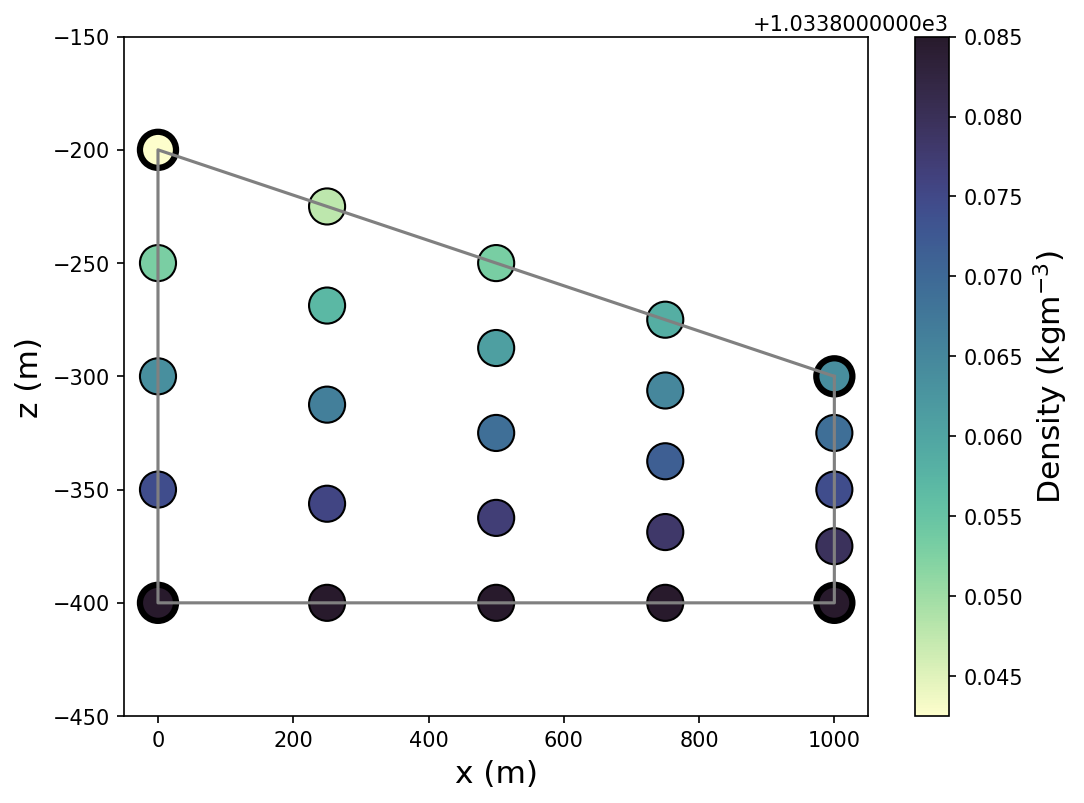

r5l [-1.197875   -1.19665872 -1.19519079 -1.19347122 -1.1915    ] actual [-1.197875   -1.19667969 -1.19521875 -1.19349219 -1.1915    ]
intz_dpal -234432.76315793957
intz_dpar -58509.089364044165
intx_dpa -1755.561308114302
(dzr-dzl) -100
(z_br-z_bl) 0
term1 -293714.5696272593
term2 293714.3311342636
term3 1.2882447665056361e-09
hl 200
hr 100
deltadpa -117790.89583336381
deltaintz -175923.6737938954
PFu= -3.0723735352681167e-10


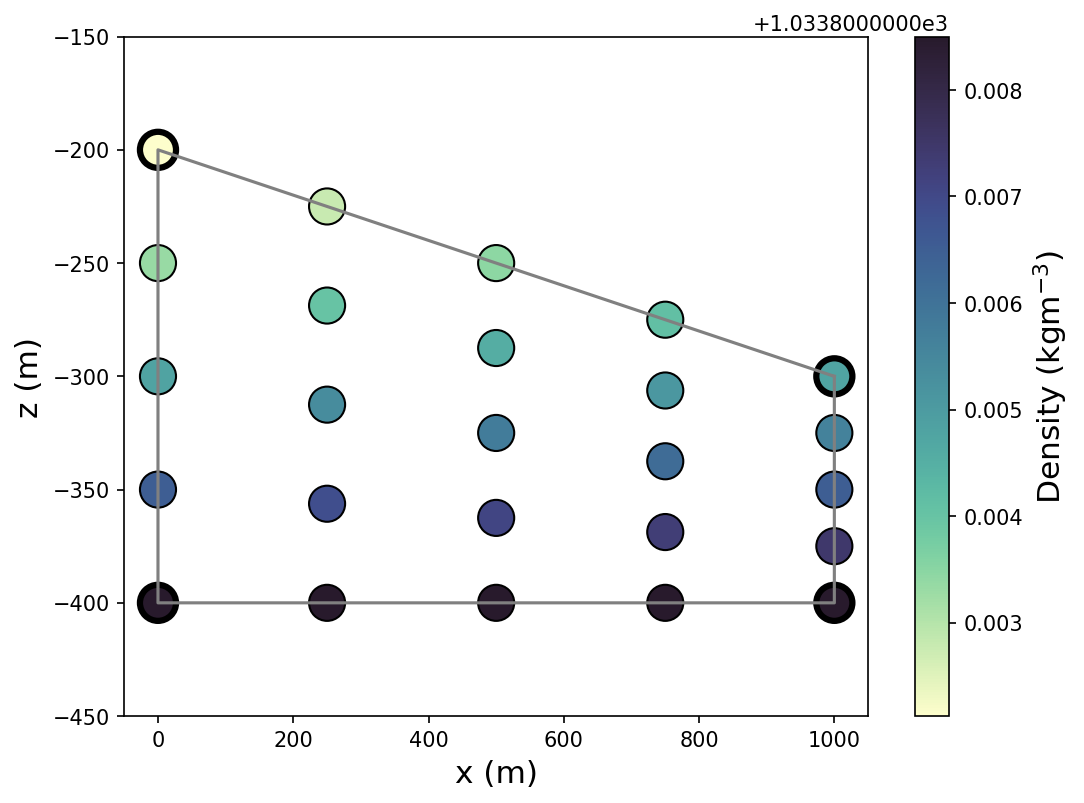

r5l [-1.197875   -1.19665872 -1.19519079 -1.19347122 -1.1915    ] actual [-1.197875   -1.19667969 -1.19521875 -1.19349219 -1.1915    ]
intz_dpal -234432.76315793957
intz_dpar -234432.76315793957
intx_dpa -2342.0600204682573
(dzr-dzl) 0
(z_br-z_bl) 0
term1 0.0
term2 -0.0
term3 9.66183574879227e-10
hl 200
hr 200
deltadpa 0.0
deltaintz 0.0
PFu= 0.0


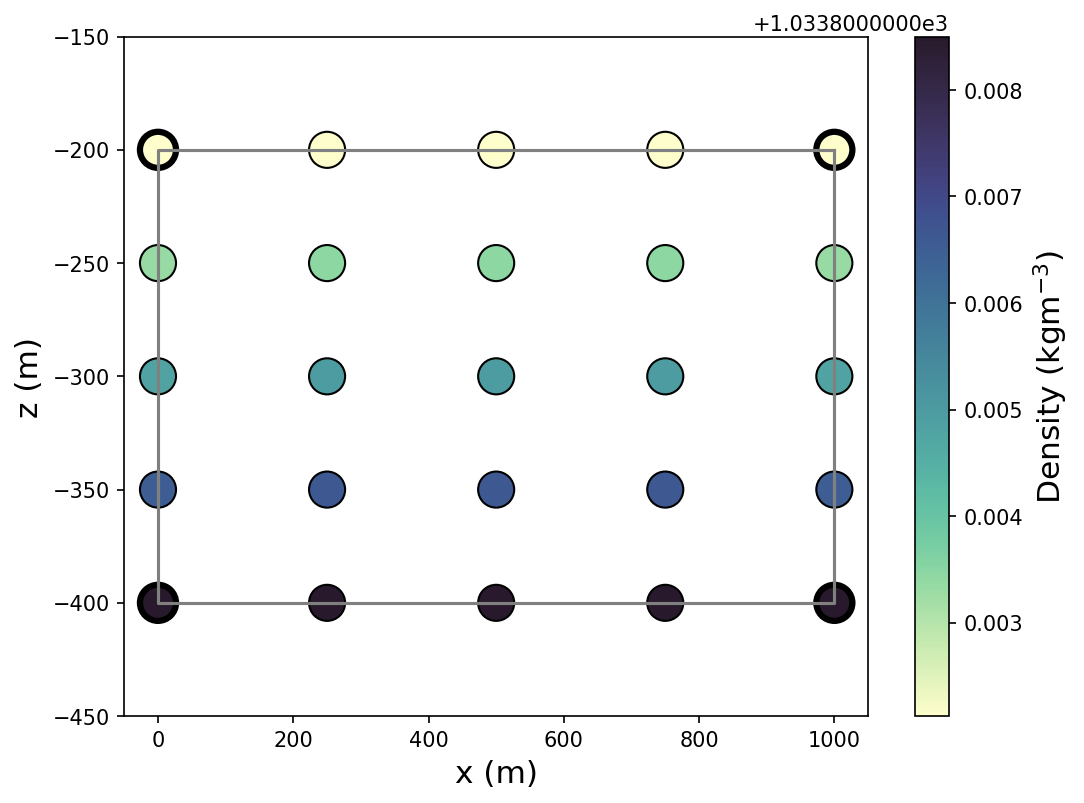

0.0

In [7]:
# check linear
pg_given_rhos_mwipg_5pt_ppm(200, 300,400,400,1, verbose = True, mwipg = False, strat = 0.85,rhoref = 1035)
# check quadratic
pg_given_rhos_mwipg_5pt_ppm(200, 300,400,400,2, verbose = True, mwipg = False, strat = 0.85,rhoref = 1035)
# check quadratic rectangle
pg_given_rhos_mwipg_5pt_ppm(200, 200,400,400,2, verbose = True, mwipg = False, strat = 0.85,rhoref = 1035)

# Check linear profile has 0 PF:

Fixes top left and bottom left grid corners to certain depths (and densities), moves bottom right and top right corners independently to explore grid cell shapes.

Indeed, for all grid cell shapes, linear density profile has zero PG force. This is expected and a sign that the above code works.

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_43971/2682120306.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(z_trs,z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-15, vmin = -5e-15)


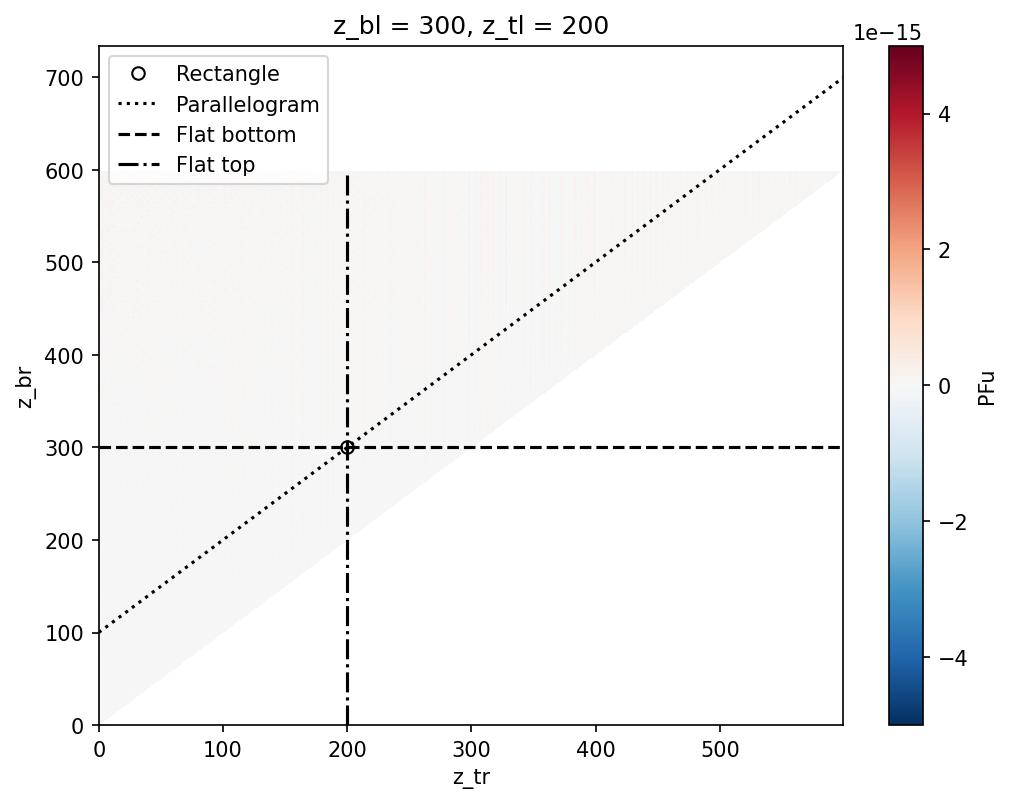

In [8]:
verbose = False
z_brs = np.arange(0,600)
z_trs = np.arange(0,600)
S2 = 1 #linear
z_tl = 200
z_bl = 300

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for i in np.arange(len(z_trs)):
        if z_trs[i] > z_brs[j]:
            PFus[j,i]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[i],z_bl,z_brs[j],S2,verbose = False)
            PFus[j,i] = PFu

fig = plt.figure(figsize = (8,6),dpi = 150)
plt.pcolormesh(z_trs,z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-15, vmin = -5e-15)
plt.plot(z_tl,z_bl, 'o', mfc='none', label = 'Rectangle',color = 'k')
plt.plot(z_trs,(z_bl-z_tl)+z_trs,color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
plt.plot(z_trs,(z_bl)+z_trs*0,color = 'k', label = 'Flat bottom', linestyle = '--' )
plt.plot(z_tl+z_brs*0,z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
plt.legend()
plt.ylabel('z_br')
plt.xlabel('z_tr')
plt.colorbar(label = 'PFu')
plt.title('z_bl = '+str(z_bl)+', z_tl = '+str(z_tl))
plt.show()


# Quadratic Profile

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_43971/3675530638.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(z_trs,z_brs,PFus, cmap = 'RdBu_r', vmax = 3e-7, vmin = -3e-7)


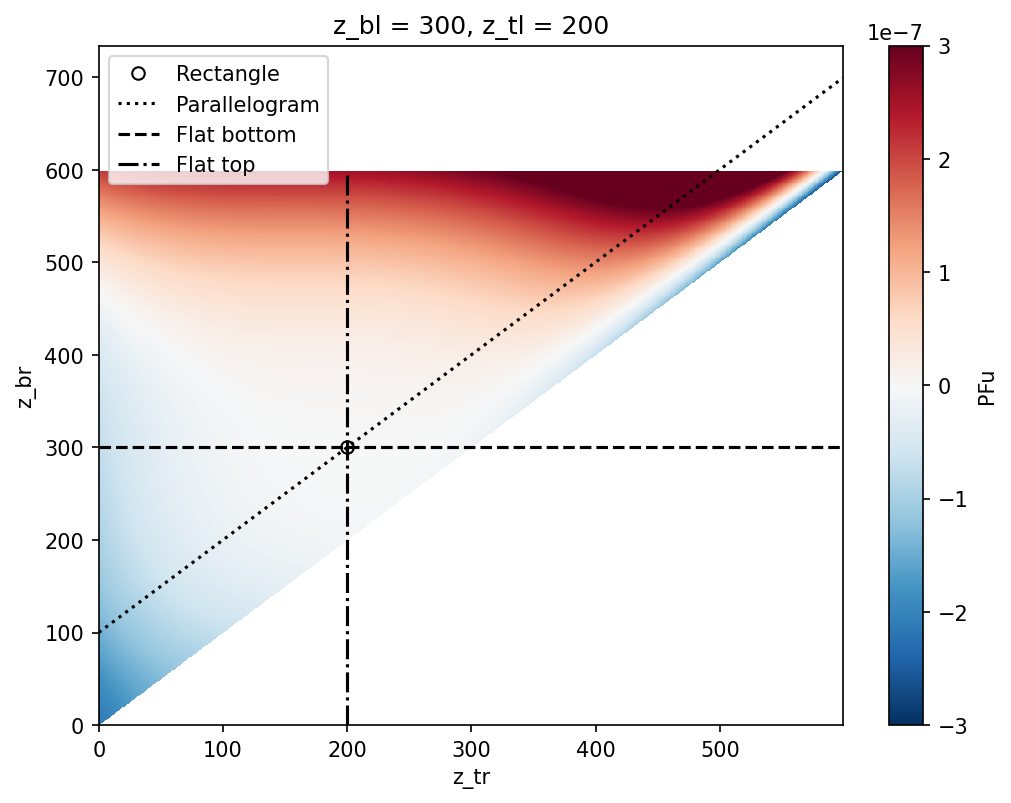

In [9]:
verbose = False
z_brs = np.arange(0,600)
z_trs = np.arange(0,600)
S2 = 2 #quadratic
z_tl = 200
z_bl = 300

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for i in np.arange(len(z_trs)):
        if z_trs[i] > z_brs[j]:
            PFus[j,i]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[i],z_bl,z_brs[j],S2,verbose = False)
            
            PFus[j,i] = PFu

fig = plt.figure(figsize = (8,6),dpi = 150)
plt.pcolormesh(z_trs,z_brs,PFus, cmap = 'RdBu_r', vmax = 3e-7, vmin = -3e-7)
plt.plot(z_tl,z_bl, 'o', mfc='none', label = 'Rectangle',color = 'k')
plt.plot(z_trs,(z_bl-z_tl)+z_trs,color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
plt.plot(z_trs,(z_bl)+z_trs*0,color = 'k', label = 'Flat bottom', linestyle = '--' )
plt.plot(z_tl+z_brs*0,z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
plt.legend()
plt.ylabel('z_br')
plt.xlabel('z_tr')
plt.colorbar(label = 'PFu')
plt.title('z_bl = '+str(z_bl)+', z_tl = '+str(z_tl))
plt.show()


# Combined plot of shapes

200m
1033.8425
1033.8421675
1033.842076889505
400m
1033.885
1033.88467
1033.8845806715274
diff
-0.04250000000001819
-0.042502499999955035
-0.04250378202232241


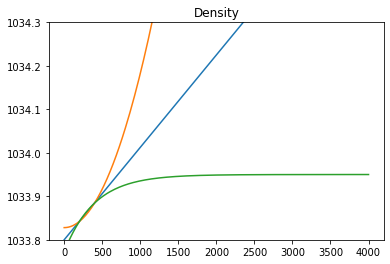

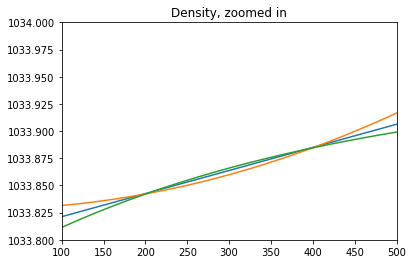

No handles with labels found to put in legend.


(0.0, 0.01)

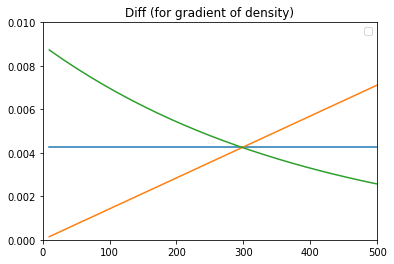

In [10]:
# Want to match densities at 200 and 400m
rhotop = 1000+33.8*1
z_bot = 4000

def rho_lin(strat,depth,rhotop = 1033.8):
    return rhotop+(depth/z_bot)**1*strat
def rho_quad(strat,depth,rhotop = 1033.8):
    return rhotop+(depth/z_bot)**2*strat #+ (depth/z_bot)**1*strat1
def rho_exp(S,depth,rhotop = 1033.8):
    return rhotop+S*(np.exp(-((depth)/z_bot*10))-1)

print('200m')
print(rho_lin(0.85,200))
print(rho_quad(5.667,200,1033.828))
print(rho_exp(-0.1781,200,1033.772))

print('400m')
print(rho_lin(0.85,400))
print(rho_quad(5.667,400,1033.828))
print(rho_exp(-0.1781,400,1033.772))

print('diff')
print(rho_lin(0.85,200)-rho_lin(0.85,400))
print(rho_quad(5.667,200,1033.828)-rho_quad(5.667,400,1033.828))
print(rho_exp(-0.1781,200,1033.772)-rho_exp(-0.1781,400,1033.772))



plt.plot(np.linspace(0,4000,200),rho_lin(0.85,np.linspace(0,4000,200),1033.8))
plt.plot(np.linspace(0,4000,200),rho_quad(5.667,np.linspace(0,4000,200),1033.828))
plt.plot(np.linspace(0,4000,200),rho_exp(-0.1781,np.linspace(0,4000,200),1033.772))
plt.ylim(1033.8,1034.3)
plt.title('Density')

plt.show()
plt.plot(np.linspace(0,4000,200),rho_lin(0.85,np.linspace(0,4000,200),1033.8))
plt.plot(np.linspace(0,4000,200),rho_quad(5.667,np.linspace(0,4000,200),1033.828))
plt.plot(np.linspace(0,4000,200),rho_exp(-0.1781,np.linspace(0,4000,200),1033.772))
plt.xlim(100,500)
plt.ylim(1033.8,1034)
plt.title('Density, zoomed in')

plt.show()

plt.plot(0.5*(np.linspace(0,4000,200)[:-1]+np.linspace(0,4000,200)[1:]),np.diff(rho_lin(0.85,np.linspace(0,4000,200),1033.8)))
plt.plot(0.5*(np.linspace(0,4000,200)[:-1]+np.linspace(0,4000,200)[1:]),np.diff(rho_quad(5.667,np.linspace(0,4000,200),1033.828)))
plt.plot(0.5*(np.linspace(0,4000,200)[:-1]+np.linspace(0,4000,200)[1:]),np.diff(rho_exp(-0.1781,np.linspace(0,4000,200),1033.772)))
plt.title('Diff (for gradient of density)')
plt.legend()
plt.xlim(0,500)
plt.ylim(0,0.01)

(0.0, -599.0)

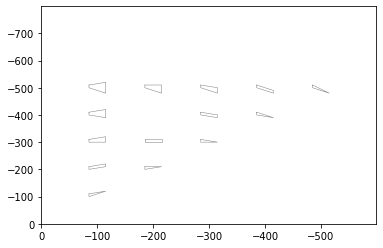

In [11]:

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False)
            PFus[j,k] = PFu
        if (k > 0) and (j > 0):
            if (k % 100 == 0) and (j % 100 == 0):
                if z_trs[k] < z_brs[j]+1:
                    if not ((z_trs[k] ==200) and (z_brs[j]==400)):
                        z_tr = -z_trs[k]
                        z_br = -z_brs[j]
                        z_tl1 = -z_tl
                        z_bl1 = -z_bl
                        
                        plt.plot([z_tr + 15,z_tr +15,z_tr - 15,z_tr - 15,z_tr + 15],
                                 [z_br - (z_tl1+300)/10,z_br - (z_bl1+300)/10,z_br - (z_br+300)/10, 
                                  z_br - (z_tr+300)/10,z_br - (z_tl1+300)/10 ],
                                  color = 'k',alpha = 0.5, linewidth = 0.5)
plt.ylim(0,-799)
plt.xlim(0,-599)

<timed exec>:71: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed exec>:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed exec>:144: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed e

CPU times: user 5min 37s, sys: 2.19 s, total: 5min 40s
Wall time: 5min 39s


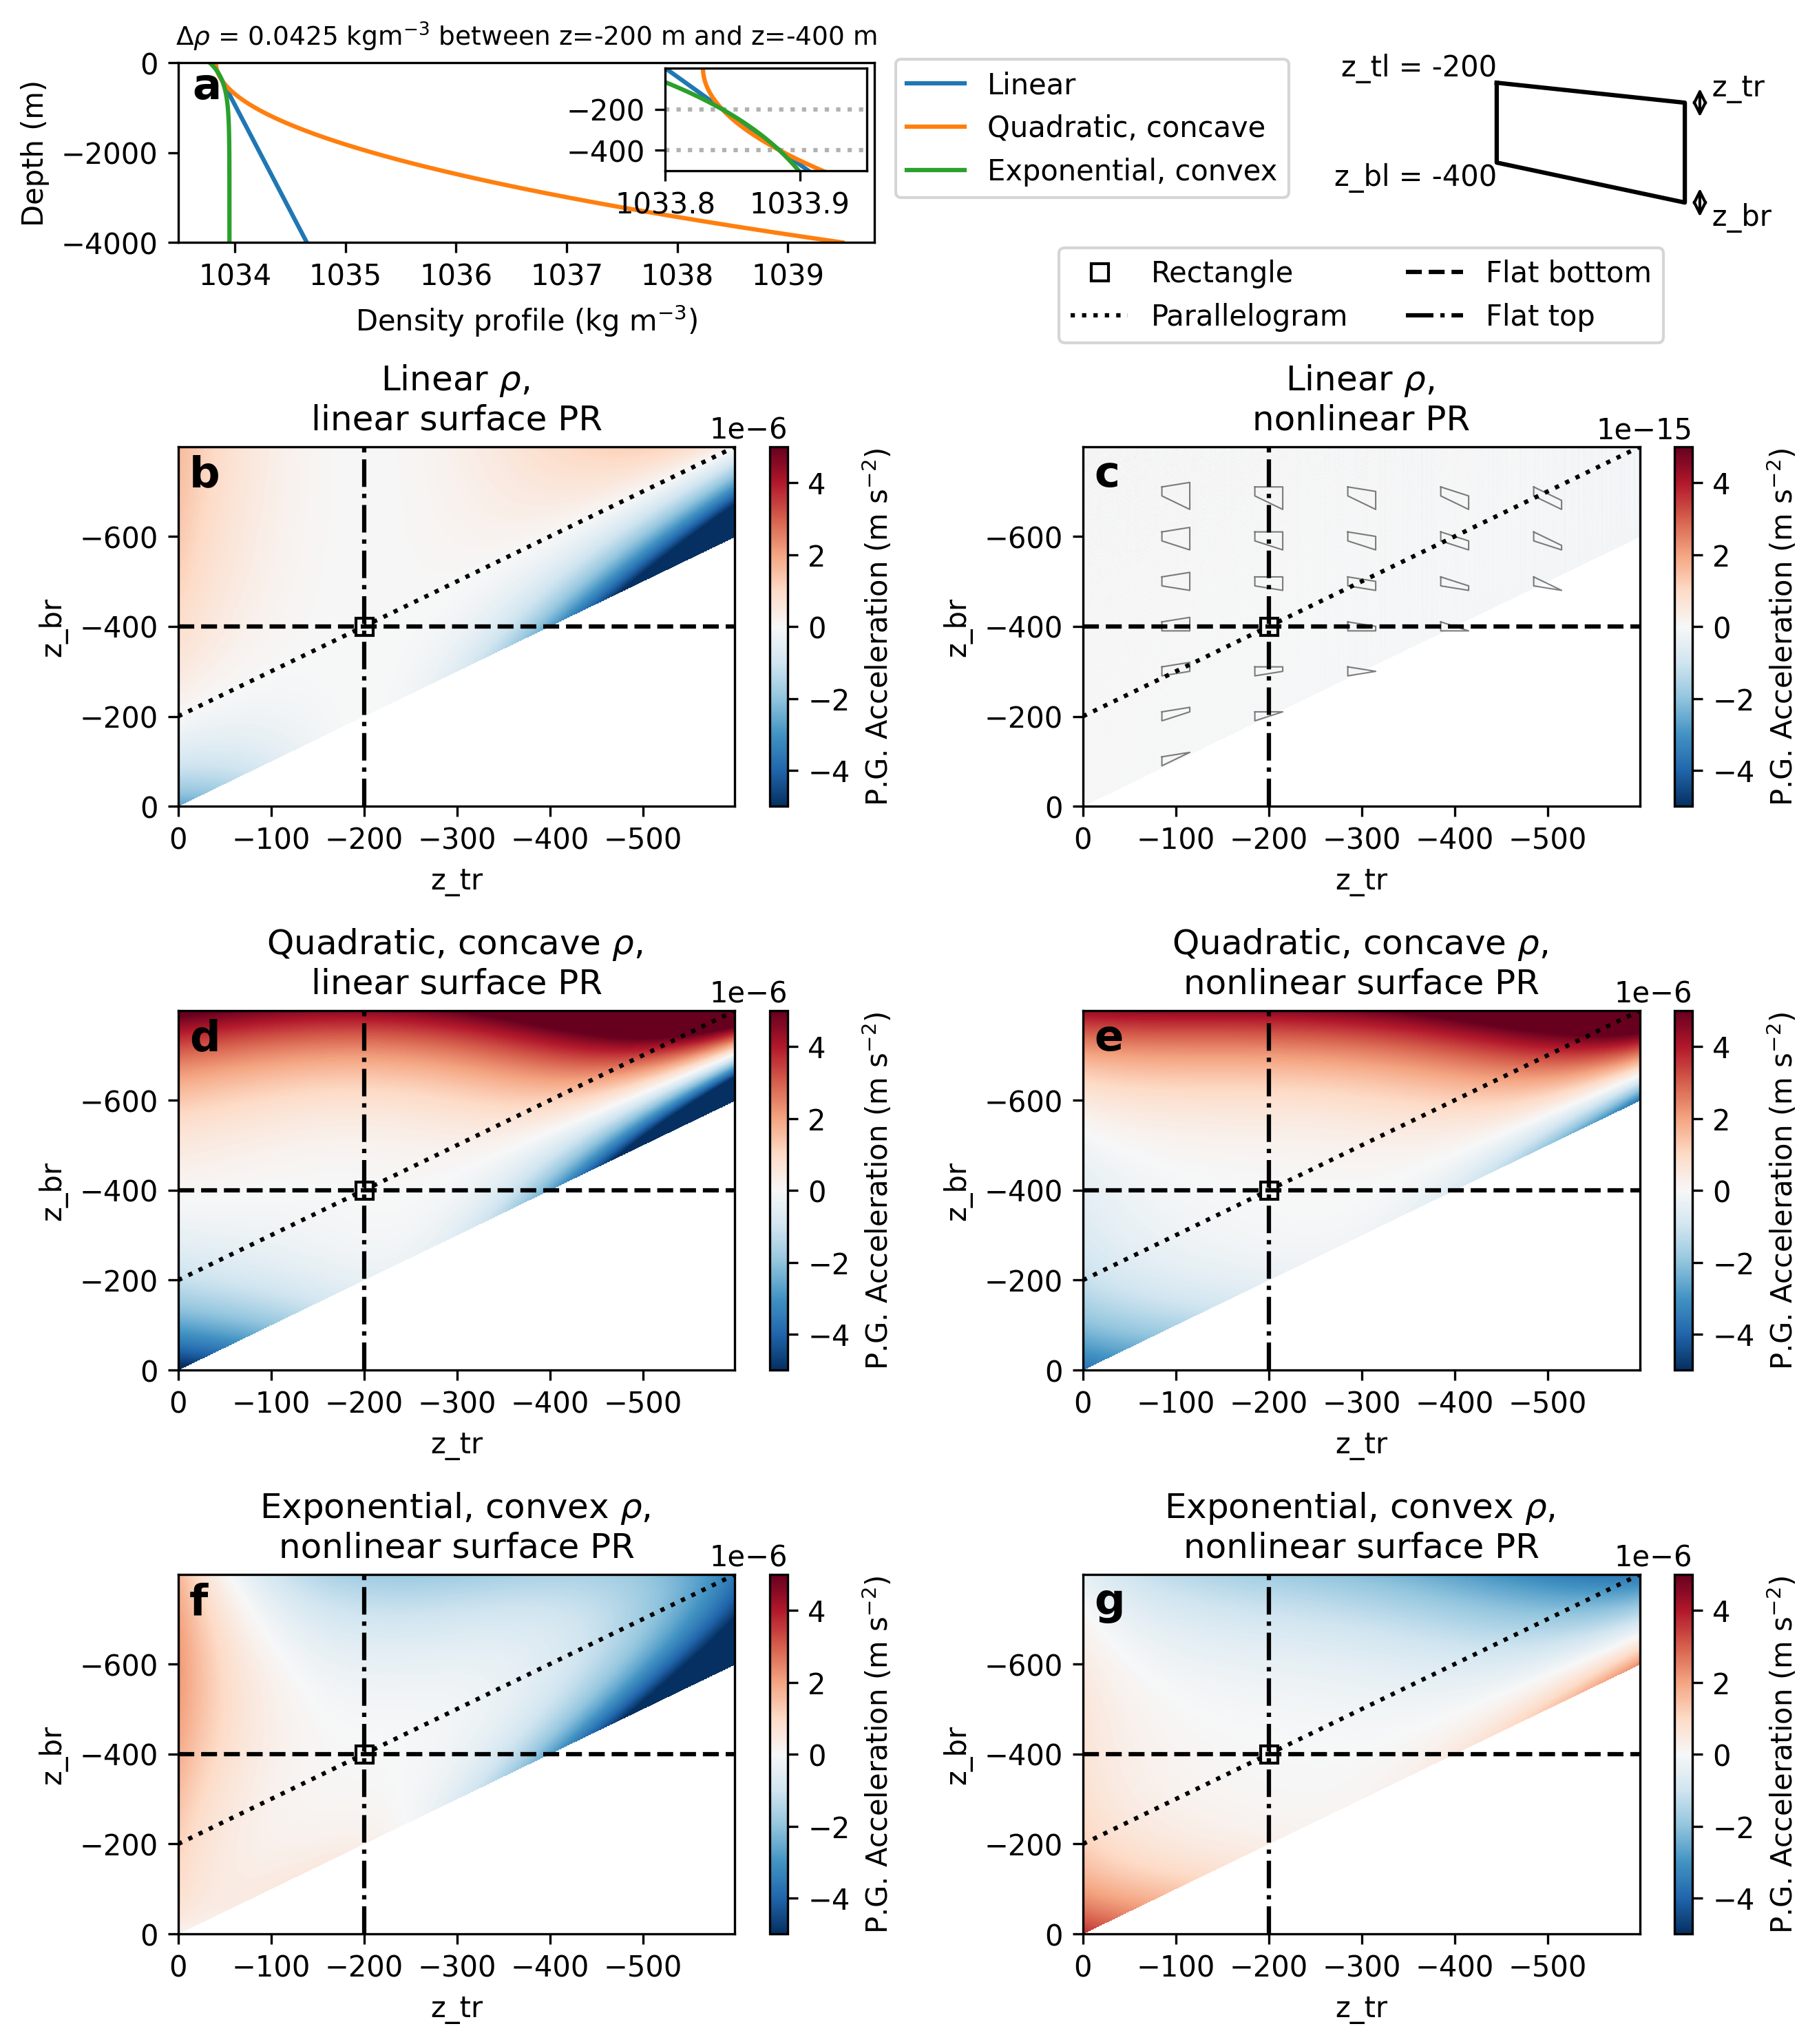

In [12]:
%%time
# version with stratification and interpretation diagram
# negative z axis, 24 Feb 25
# shifted so rho200 and rho400 match
# print(rho_lin(0.85,400))
# print(rho_quad(5.667,400,1033.828))
# print(rho_exp(-0.1781,400,1033.772))
#FINAL!!


fig, axes = plt.subplots(nrows = 4, ncols = 2, gridspec_kw={'height_ratios': [0.5,1,1,1]},figsize = (10,12),dpi = 300)
ax = np.ravel(axes)

i = 0
ax[i].plot(rho_lin(0.85,np.linspace(0,4000,200),1033.8),-np.linspace(0,4000,200),label = 'Linear')
ax[i].plot(rho_quad(5.667,np.linspace(0,4000,200),1033.828),-np.linspace(0,4000,200),label = 'Quadratic, concave')
ax[i].plot(rho_exp(-0.1781,np.linspace(0,4000,200),1033.772),-np.linspace(0,4000,200),label = 'Exponential, convex')
ax[i].set_ylim(-4000,0)
ax[i].legend(loc = 'upper left', bbox_to_anchor = (1.01,1.1))
ax[i].set_xlabel(r'Density profile (kg m$^{-3}$)')
ax[i].set_ylabel('Depth (m)')
ax[0].set_title(r'$\Delta\rho$ = 0.0425 kgm$^{-3}$ between z=-200 m and z=-400 m', fontsize = 9)

ax_inset = ax[i].inset_axes(
    [0.7, 0.4, 0.29, 0.57],
    xlim=(1033.8,1033.95),
    ylim=(-500,0), xticks = [1033.8,1033.9],xticklabels=[1033.8,1033.9], yticks=[-400,-200])
ax_inset.yaxis.label.set_fontsize(8)
ax_inset.xaxis.label.set_fontsize(8)
ax_inset.hlines([-200,-400],1033.8,1033.95,color = 'k',alpha = 0.3,linestyle = 'dotted')
ax_inset.plot(rho_lin(0.85,np.linspace(0,4000,200),1033.8),-np.linspace(0,4000,200),)
ax_inset.plot(rho_quad(5.667,np.linspace(0,4000,200),1033.828),-np.linspace(0,4000,200),)
ax_inset.plot(rho_exp(-0.1781,np.linspace(0,4000,200),1033.772),-np.linspace(0,4000,200),)

i = 1
ax[i].plot([1,1,2,2,1],[200,400,500,250,200],color = 'k')
ax[i].set_xlim(-1.2,2.5)
ax[i].set_ylim(600,150)
ax[i].text(1,200,'z_tl = -200', ha = 'right', va = 'bottom')
ax[i].text(1,400,'z_bl = -400', ha = 'right', va = 'top')
ax[i].text(2,250,'   z_tr', ha = 'left', va = 'bottom')
ax[i].text(2,500,'   z_br', ha = 'left', va = 'top')

ax[i].annotate("", xy=(2.08,300), xytext=(2.08, 200),
            arrowprops=dict(arrowstyle="<->"))
ax[i].annotate("", xy=(2.08,550), xytext=(2.08, 450),
            arrowprops=dict(arrowstyle="<->"))

ax[i].set_axis_off()


#linear
rhotop = 1033.8
i = 2
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 1 #linear
z_tl = 200
z_bl = 400

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False,rhotop=rhotop,
                                            LSPR = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Linear $\rho$, '+'\nlinear surface PR')

i = 3
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 1 #linear

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False,rhotop=rhotop)
            PFus[j,k] = PFu
        if (k > 0) and (j > 0):
            if (k % 100 == 0) and (j % 100 == 0):
                if z_trs[k] < z_brs[j]+1:
                    if not ((z_trs[k] ==200) and (z_brs[j]==400)):
                        z_tr = -z_trs[k]
                        z_br = -z_brs[j]
                        z_tl1 = -z_tl
                        z_bl1 = -z_bl
                        
                        ax[i].plot([z_tr + 15,z_tr +15,z_tr - 15,z_tr - 15,z_tr + 15],
                                 [z_br - (z_tl1+300)/10,z_br - (z_bl1+300)/10,z_br - (z_br+300)/10, 
                                  z_br - (z_tr+300)/10,z_br - (z_tl1+300)/10 ],
                                  color = 'k',alpha = 0.5, linewidth = 0.5)

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-15, vmin = -5e-15)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
ax[i].legend(bbox_to_anchor = (0.5,1.25),loc = 'lower center', ncol = 2)
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Linear $\rho$, '+'\nnonlinear PR')

#quadratic
rhotop = 1033.828

i = 4
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 2 #quadratic

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False, strat = 5.667,rhotop=rhotop,
                                            LSPR = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Quadratic, concave $\rho$, '+'\nlinear surface PR')

i = 5
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 2 #quadratic

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False, strat = 5.667,rhotop=rhotop)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Quadratic, concave $\rho$, '+'\nnonlinear surface PR')

#exponential
rhotop=1033.772
i = 6
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = -0.1781 #(was 10??)

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],10,verbose = False,strat = -0.1781,rhotop=rhotop,
                                            LSPR = True, exponential = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Exponential, convex $\rho$, '+'\nnonlinear surface PR')

i = 7
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 2 #quadratic
PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],10,verbose = False,strat = -0.1781,rhotop=rhotop,
                                            exponential = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Exponential, convex $\rho$, '+'\nnonlinear surface PR')

for i in np.array([0,2,3,4,5,6,7]):
    ax[i].text(0.02,0.98,['a','a','b','c','d','e','f','g','h','i','j'][i], fontsize = 15, transform=ax[i].transAxes, fontweight='bold', va='top', zorder = 20)


fig.subplots_adjust(hspace = 0.65,wspace = 0.3)

# diagram of MWIPG

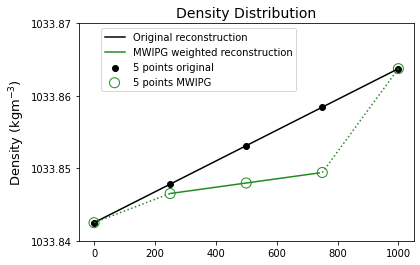

In [14]:
def mwipg_density_changes(axes,z_tl, z_tr,z_bl,z_br):
    
    rho_tl = 1033.8+z_tl*0.85/4000
    rho_tr = 1033.8+z_tr*0.85/4000
    rho_bl = 1033.8+z_bl*0.85/4000
    rho_br = 1033.8+z_br*0.85/4000

    if (z_tl > z_bl) or (z_tr > z_br):
        raise Exception("bottom depth shallower than top ")
    dzl = z_bl - z_tl
    dzr = z_br - z_tr

    hWght = max(0., z_tl-z_br, z_tr-z_bl)
#        hWght = max(hWght,hWghtis)
    #print(hWght)
    if (hWght > 0.):
        dz_subroundoff = 1e-15
        hL = (dzl) + dz_subroundoff
        hR = (dzr) + dz_subroundoff
        hWght = hWght * ( (hL-hR)/(hL+hR) )**2
        iDenom = 1./( hWght*(hR + hL) + hL*hR )
        rho_tl2 = ( (hWght*hR)*rho_tr + (hWght*hL + hR*hL)*rho_tl) * iDenom
        rho_tr2 = ( (hWght*hL)*rho_tl + (hWght*hR + hR*hL)*rho_tr ) * iDenom
        rho_bl2 = ( (hWght*hR)*rho_br + (hWght*hL + hR*hL)*rho_bl ) * iDenom
        rho_br2 = ( (hWght*hL)*rho_bl + (hWght*hR + hR*hL)*rho_br ) * iDenom
    else:
        raise Exception("mwipg not activated")
    xs = np.linspace(0,1,101)
    rhot = rho_tl+(rho_tr-rho_tl)*xs**1
    rhob = rho_bl+(rho_br-rho_bl)*xs**1
    rhot2 = rho_tl2+(rho_tr2-rho_tl2)*xs**1
    rhob2 = rho_bl2+(rho_br2-rho_bl2)*xs**1
    #print(rho_tl,rho_tr,rho_br,rho_bl)
    #print(rho_tl2,rho_tr2,rho_br2,rho_bl2)
    
    xs = xs*1000
    
    axes.plot(xs,rhot,label = 'Original reconstruction',color = 'k')
    axes.scatter(xs[0::25],rhot[0::25],color = 'k', label = '5 points original')
    axes.plot(xs[25:75],rhot2[25:75],label = 'MWIPG weighted reconstruction',color = 'forestgreen')
    
    axes.scatter(xs[25:-25:25],rhot2[25:-25:25],edgecolors= "forestgreen",s = 100, facecolors='none')
    axes.scatter(xs[0::100],rhot[0::100],edgecolors= "forestgreen",s = 100, facecolors='none', label = '5 points MWIPG')
    axes.plot([xs[0],xs[25]],[rhot[0],rhot2[25]],color = 'forestgreen', linestyle = 'dotted')
    axes.plot([xs[75],xs[100]],[rhot2[75],rhot[100]],color = 'forestgreen', linestyle = 'dotted')
    

    #axes.set_xlabel('normalised $x$ position', fontsize = 13)
    axes.set_ylabel('Density (kgm$^{-3}$)', fontsize = 13)
    axes.set_title('Density Distribution', fontsize = 14)# Density Distribution')
#     cbar.formatter.set_powerlimits((0, 0))
#     cbar.formatter.set_useMathText(True)
#    axes.yaxis.set_offset_position('left')
    axes.yaxis.set_major_formatter('{x:7<.2f}')
    axes.set_yticks([1033.84,1033.85,1033.86,1033.87])


    axes.legend(loc = 'upper left',bbox_to_anchor = (0.05,1))
    
fig,axes = plt.subplots()
mwipg_density_changes(axes,200, 300,250,310)



(-110.0, 1110.0)

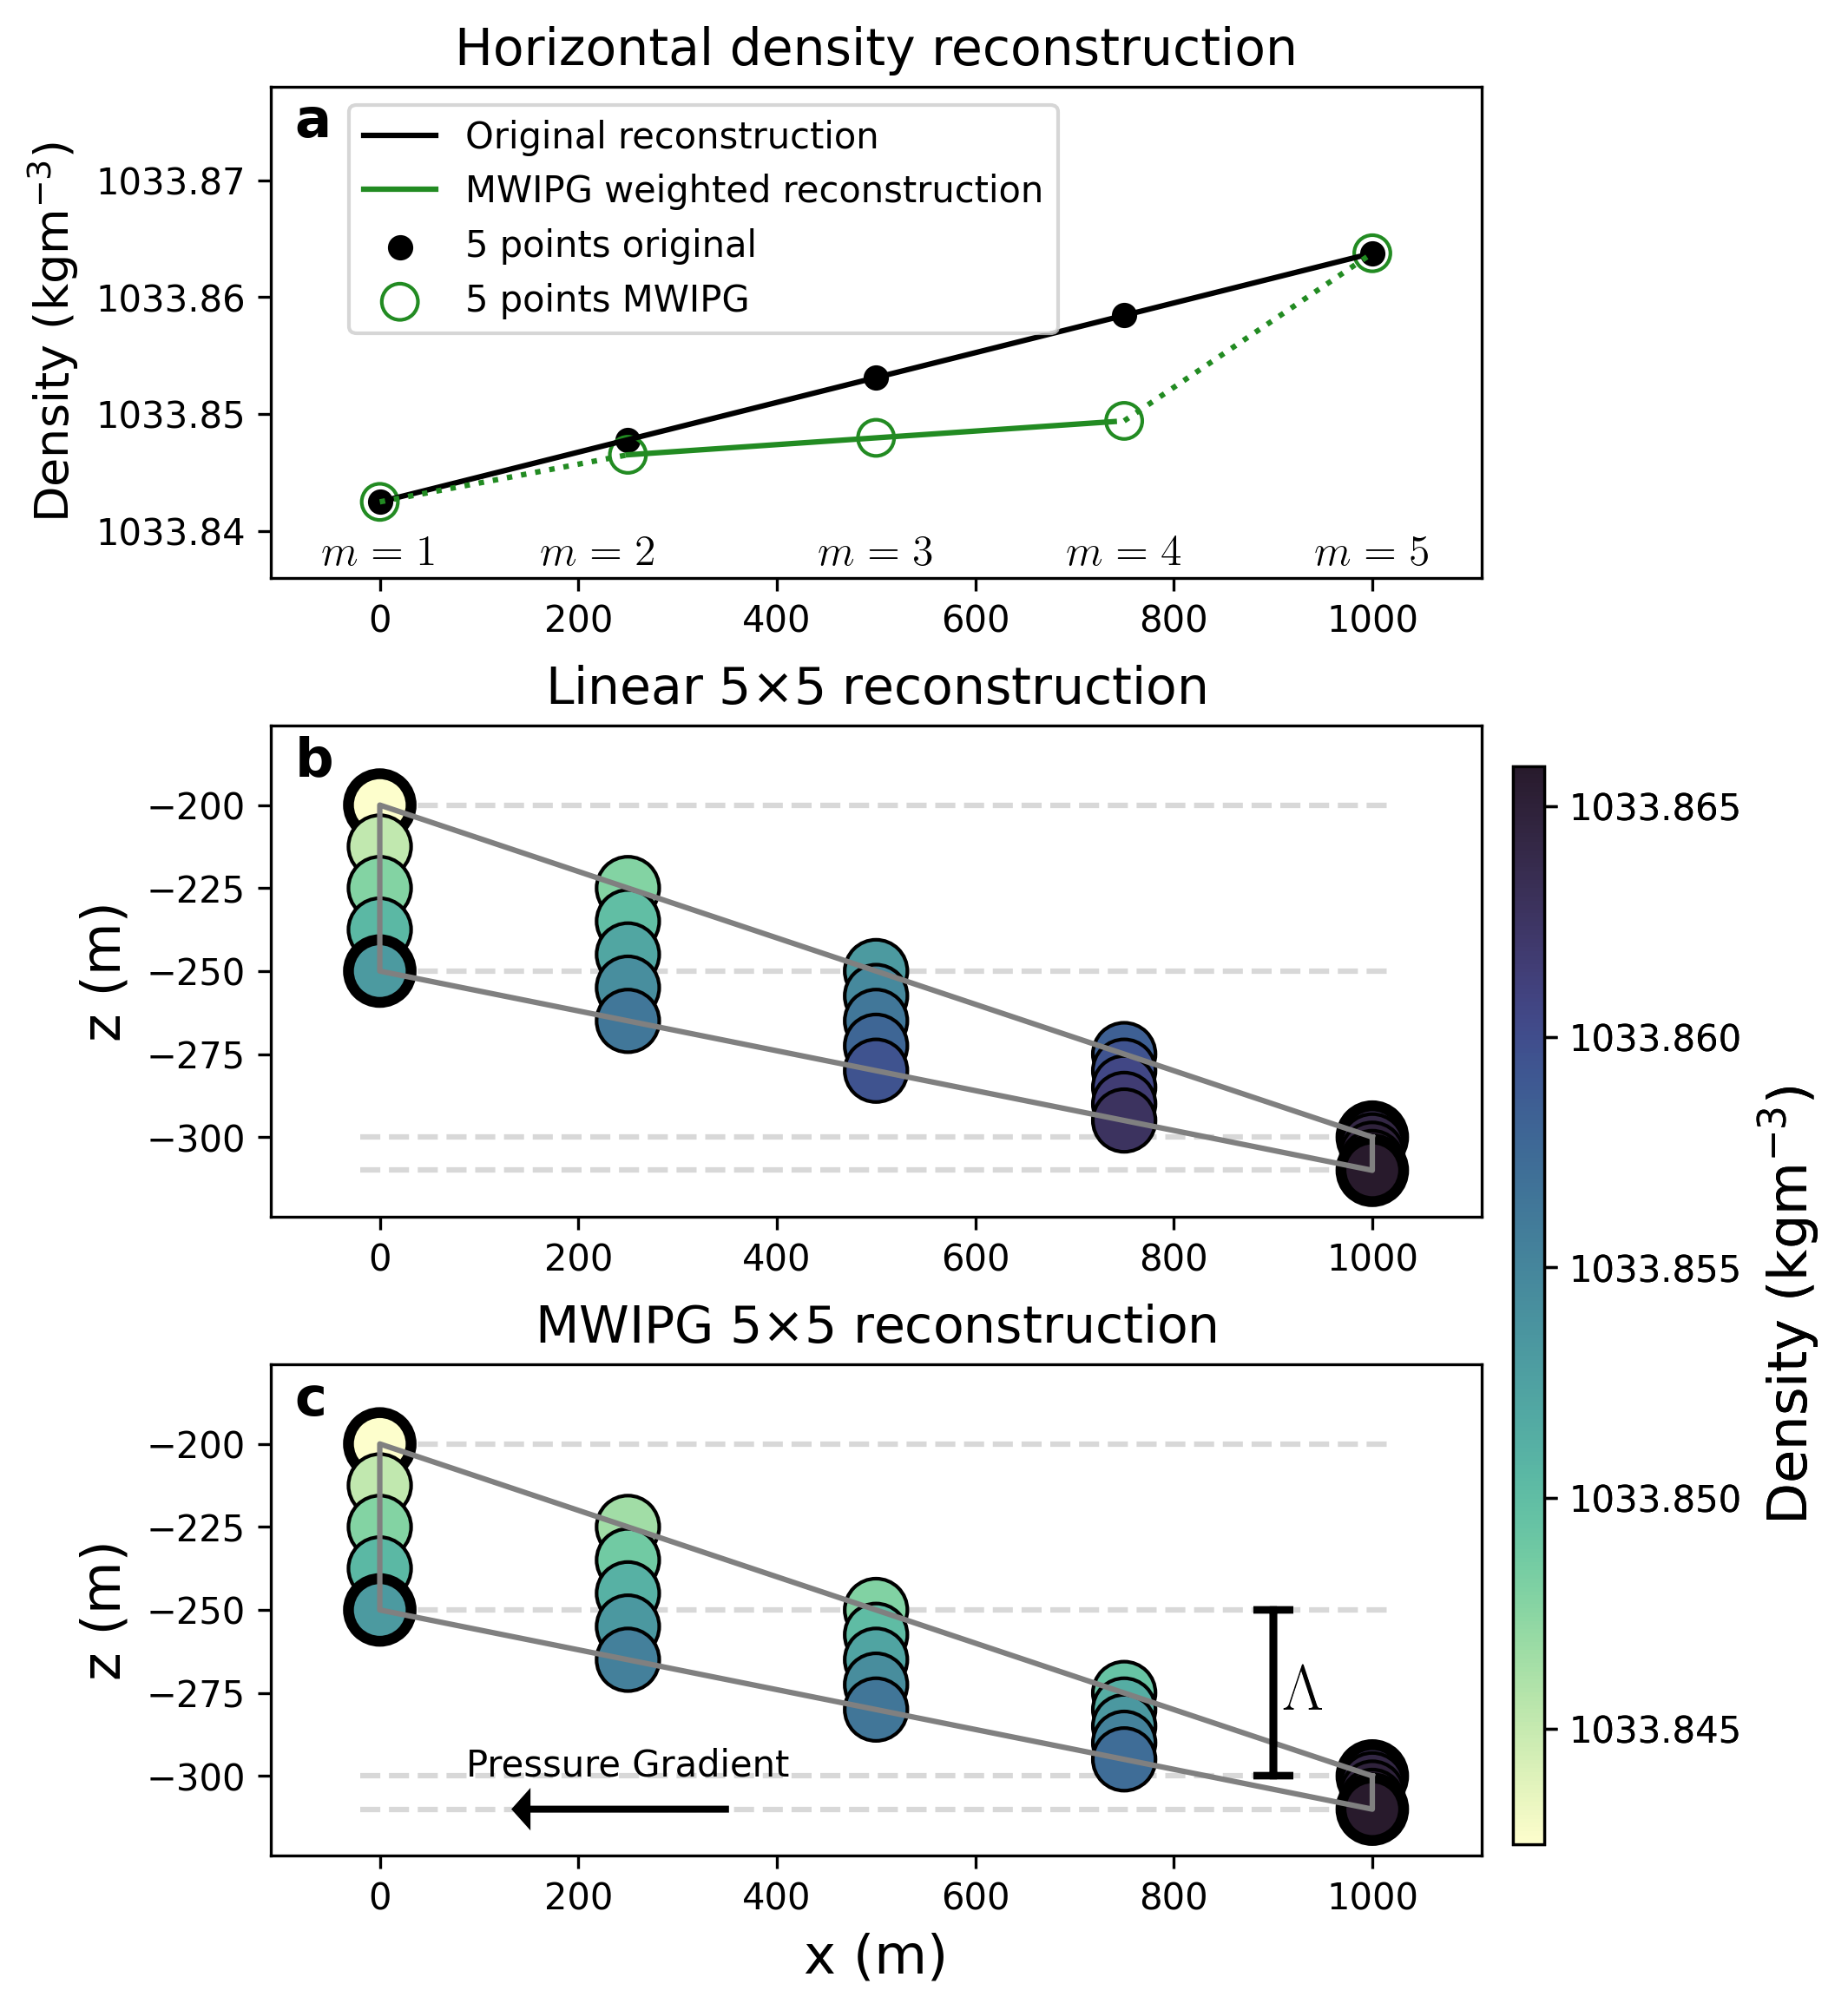

In [15]:
plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(nrows = 3,ncols = 1, figsize = (6,9),dpi = 300)


axes[1].hlines([-200,-250,-300,-310],-20,1020,color = 'gray',alpha=0.3,linestyle = '--',zorder = 1)
axes[2].hlines([-200,-250,-300,-310],-20,1020,color = 'gray',alpha=0.3,linestyle = '--',zorder = 1)

pg_given_rhos_mwipg_5pt_ppm(200, 300,250,310,1,verbose = False, mwipg = False, strat = 0.85,rhoref = 1035,
                           fancy_fig = True, ax = axes[1])
pg_given_rhos_mwipg_5pt_ppm(200, 300,250,310,1,verbose = False, mwipg = True, strat = 0.85,rhoref = 1035,
                           fancy_fig = True, ax = axes[2])
mwipg_density_changes(axes[0],200, 300,250,310)

axes[1].set_xlabel('')
axes[1].set_title(r'Linear 5$\times$5 reconstruction',fontsize = 14)
axes[2].set_title(r'MWIPG 5$\times$5 reconstruction',fontsize = 14)
axes[0].set_title(r'Horizontal density reconstruction',fontsize = 14)

axes[2].arrow(350,-310,-200,0,width=1,head_width=10,color = 'k')
axes[2].text(250,-300,'Pressure Gradient', ha = 'center')

axes[2].arrow(900,-300,0,50,head_width = 40,head_length=0,color = 'k', lw = 2, zorder = 10)
axes[2].arrow(900,-250,0,-50,head_width = 40,head_length=0,color = 'k', lw = 2, zorder = 10)
plt.rcParams['text.usetex'] = True
axes[2].text(910,-275,'$\Lambda$',ha = 'left',va = 'center',fontsize = 18)
fig.subplots_adjust(hspace = 0.3)

axes[0].text(0,1033.838,'$m=1$',va = 'center', ha = 'center', fontsize = 12)
axes[0].text(220,1033.838,'$m=2$',va = 'center', ha = 'center', fontsize = 12)
axes[0].text(500,1033.838,'$m=3$',va = 'center', ha = 'center', fontsize = 12)
axes[0].text(750,1033.838,'$m=4$',va = 'center', ha = 'center', fontsize = 12)
axes[0].text(1000,1033.838,'$m=5$',va = 'center', ha = 'center', fontsize = 12)

plt.rcParams['text.usetex'] = False

for i in np.array([0,1,2]):
    axes[i].text(0.02,0.98,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 15, transform=axes[i].transAxes, fontweight='bold', va='top', zorder = 20)

axes[0].set_ylim(1033.836,1033.878)
axes[1].set_ylim(-324,-176)
axes[2].set_ylim(-324,-176)

axes[0].set_xlim(-110,1110)
axes[1].set_xlim(-110,1110)
axes[2].set_xlim(-110,1110)

#FINAL!


# test mwipg

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_43971/2645617207.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = plt.pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)


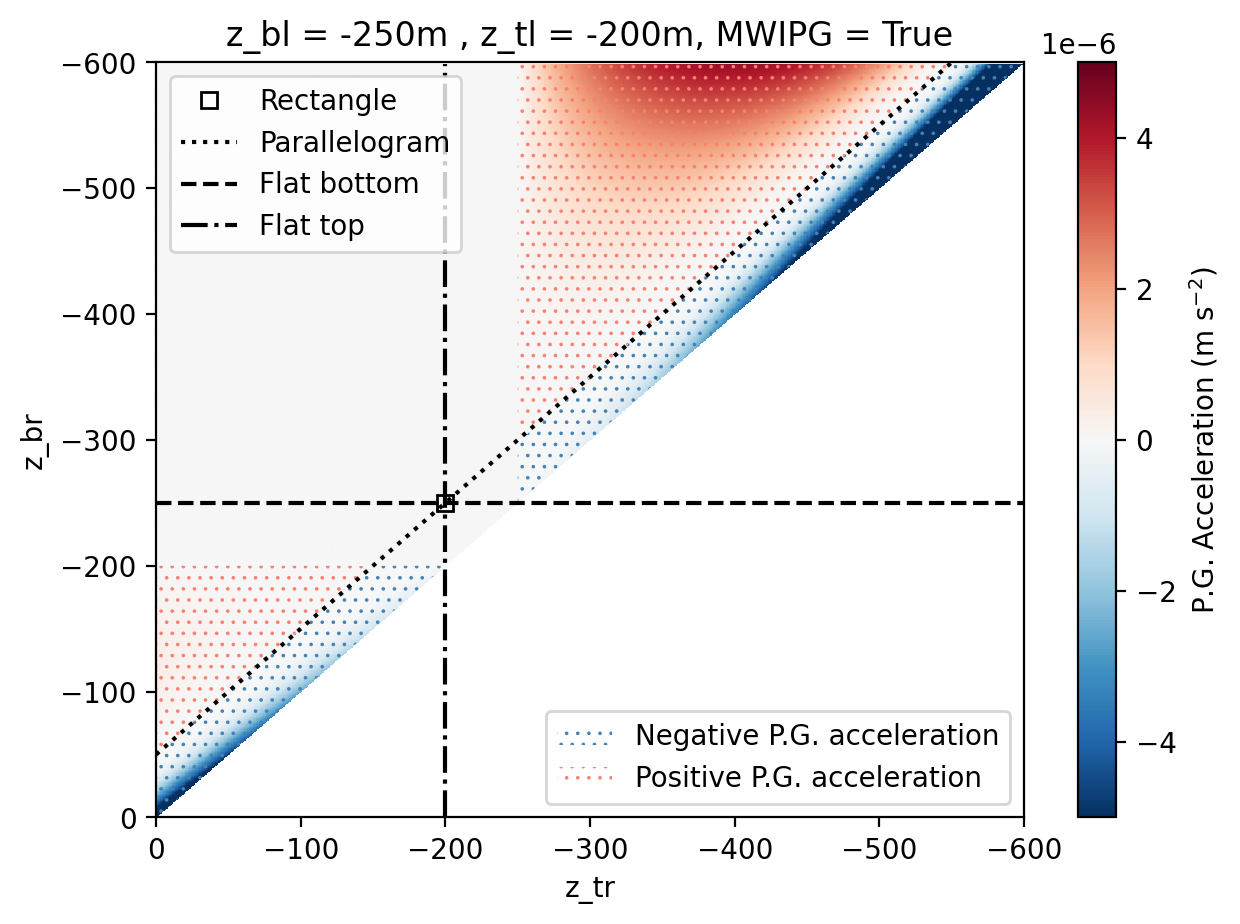

In [16]:
verbose = False
z_brs = np.arange(0,600)
z_trs = np.arange(0,600)
S2 = 1 #linear
z_tl = 200
z_bl = 250

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for i in np.arange(len(z_trs)):
        if z_trs[i] > z_brs[j]:
            PFus[j,i]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[i],z_bl,z_brs[j],S2,mwipg = True,verbose = False)
            PFus[j,i] = PFu

fig = plt.figure(figsize = (7,5),dpi = 200)
cs = plt.pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
plt.rcParams['hatch.color'] = 'steelblue'
plt.rcParams['hatch.linewidth'] = 0.5
cs2 = plt.contourf(-z_trs,-z_brs,PFus, levels = [-1,-1e-12],colors = 'none',hatches = ['...'])
plt.rcParams['hatch.color'] = 'salmon'
plt.rcParams['hatch.linewidth'] = 0.5

cs3 = plt.contourf(-z_trs,-z_brs,PFus, levels = [1e-12,1],colors = 'none',hatches = ['...'] )
plt.rcParams['hatch.color'] = 'steelblue'
plt.rcParams['hatch.linewidth'] = 0.5
h2,l1 = cs2.legend_elements()
plt.rcParams['hatch.color'] = 'salmon'
plt.rcParams['hatch.linewidth'] = 0.5
h3,l1 = cs3.legend_elements()

legend1 = plt.legend([ h2[0],h3[0]], ['Negative P.G. acceleration','Positive P.G. acceleration'], loc = 'lower right')


plt.plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
plt.plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
plt.plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
plt.plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
plt.xlim(0,-600)
plt.ylim(0,-600)

plt.legend(loc = 'upper left')
pyplot.gca().add_artist(legend1)
plt.ylabel('z_br')
plt.xlabel('z_tr')
plt.colorbar(cs,label = 'P.G. Acceleration (m s$^{-2}$)')
plt.title('z_bl = '+str(-z_bl)+'m , z_tl = '+str(-z_tl)+'m, MWIPG = True')
plt.show()

#FINAL!


# Theoretical surface pressure (analytic)

<timed exec>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed exec>:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed exec>:88: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
<timed exe

CPU times: user 6min 21s, sys: 2.5 s, total: 6min 23s
Wall time: 6min 24s


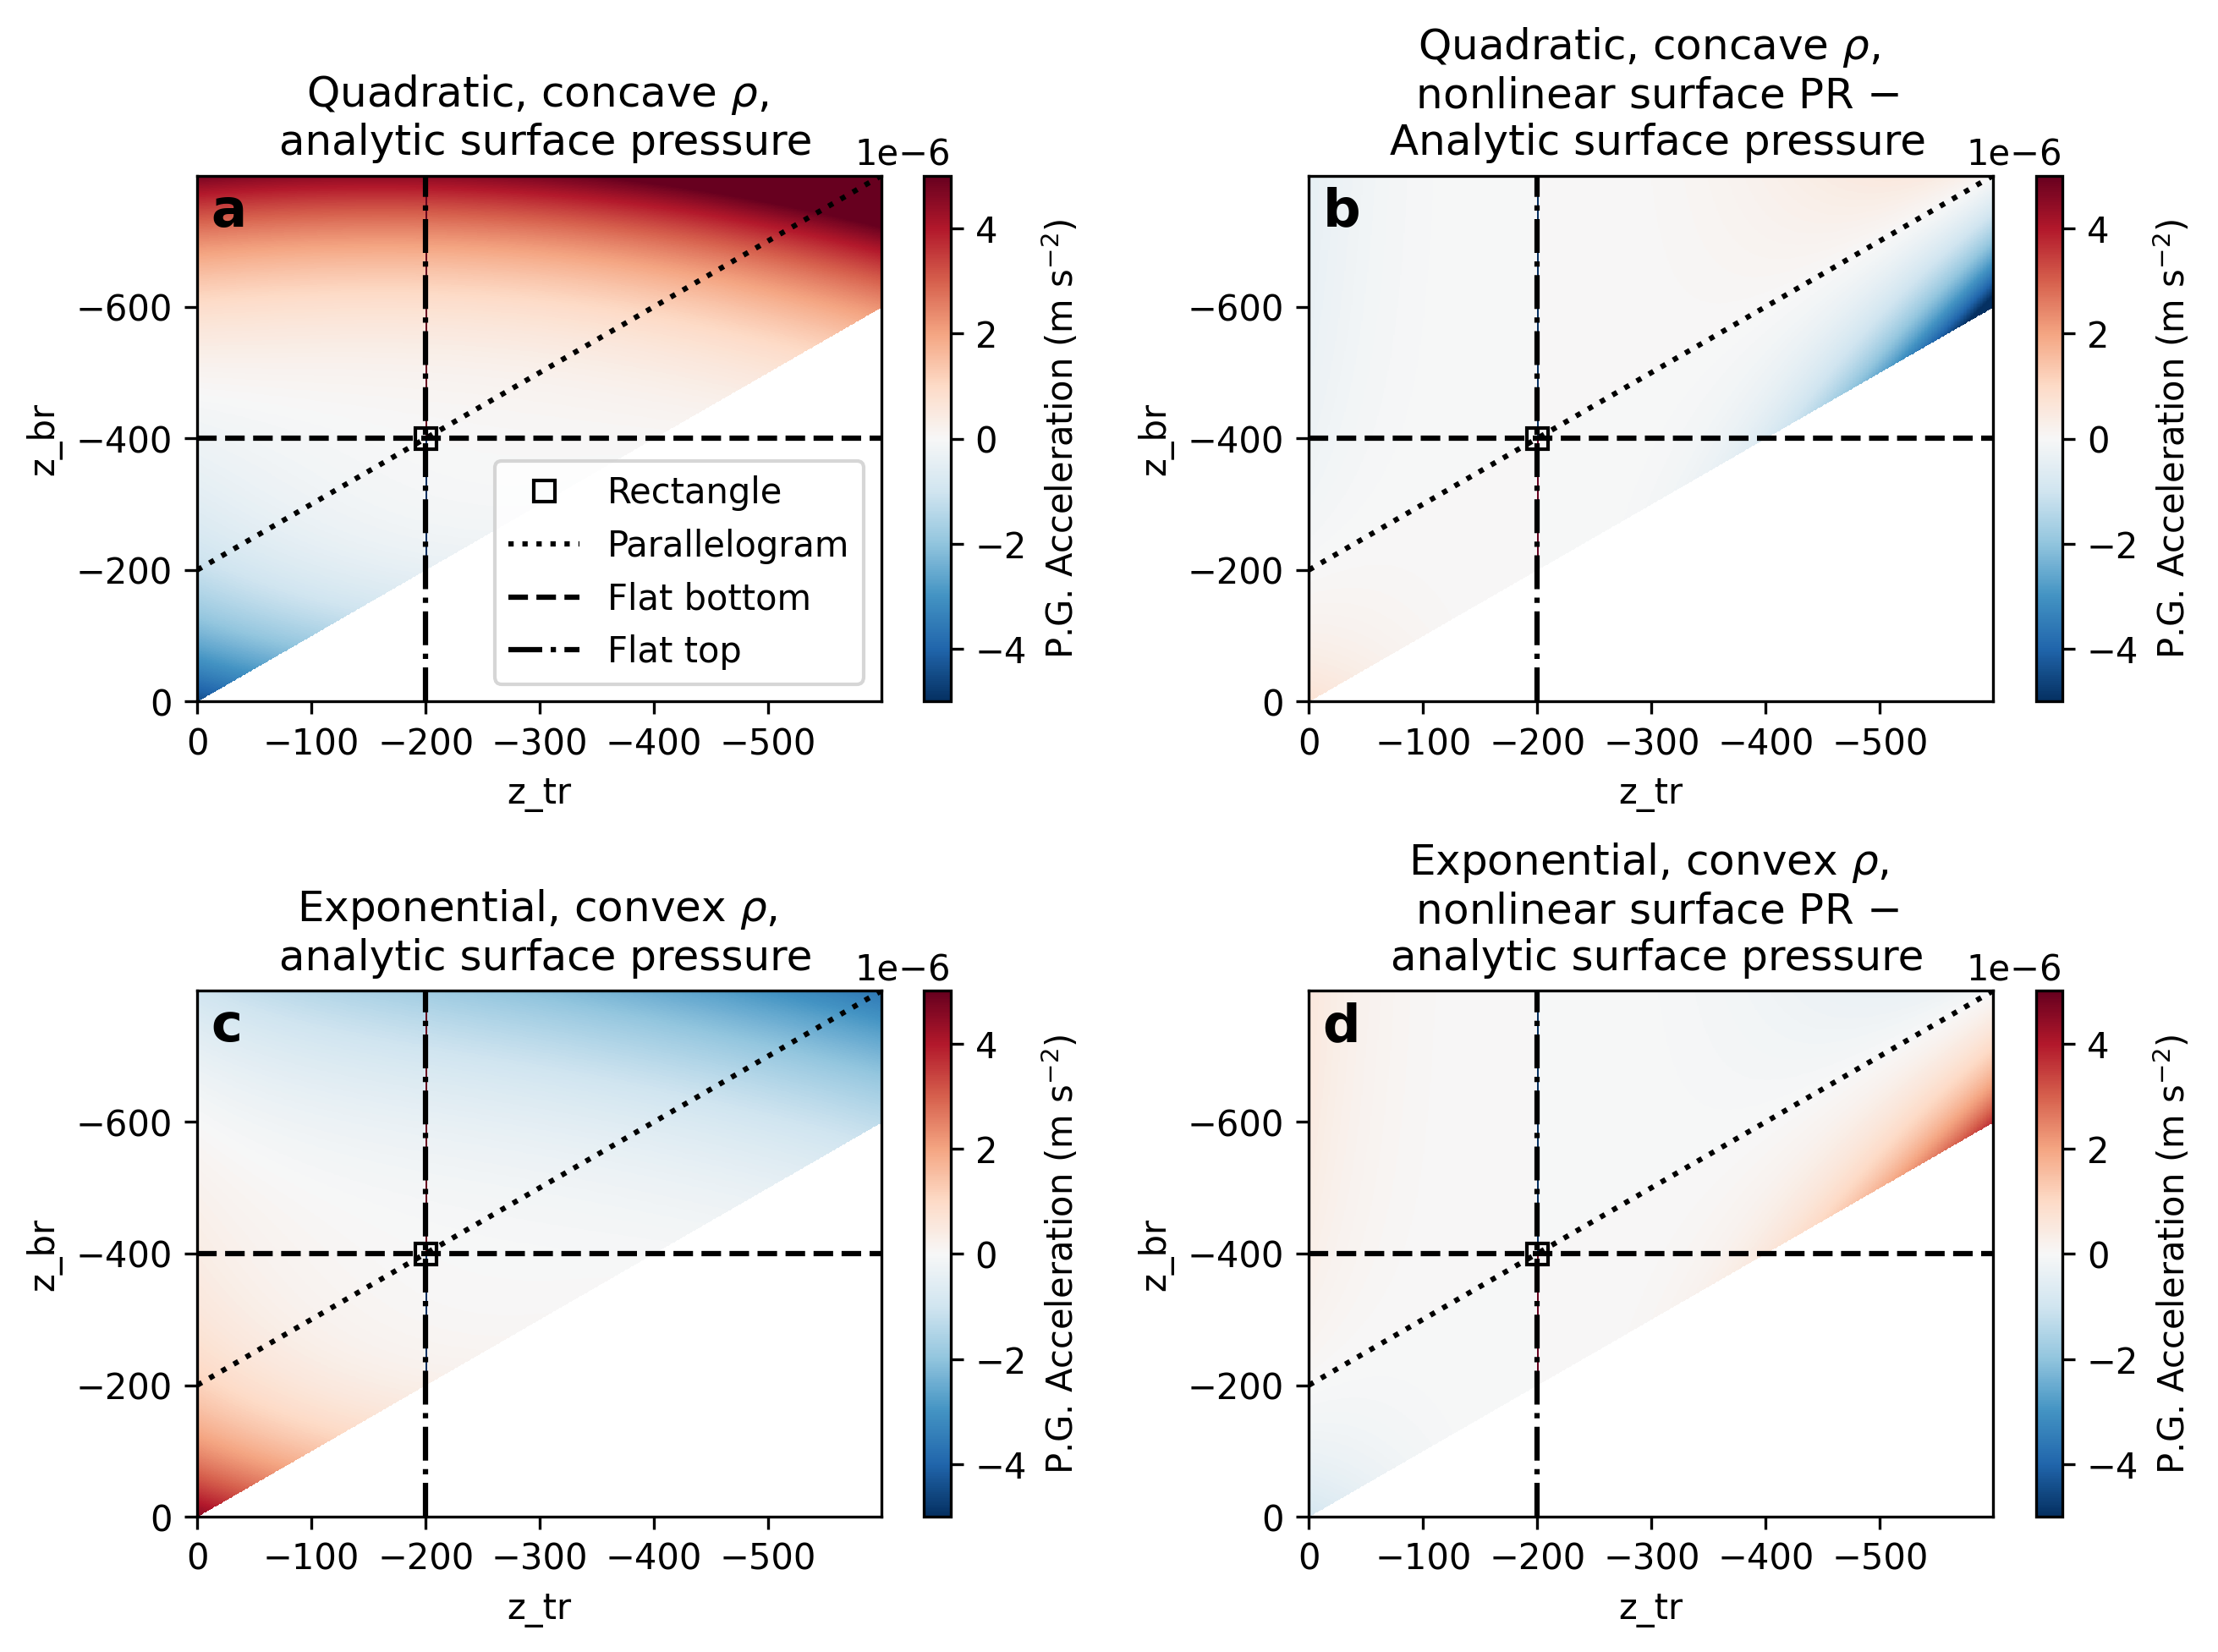

In [17]:
%%time

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize = (10,7),dpi = 300)
ax = np.ravel(axes)

z_tl = 200
z_bl = 400


i = 0
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 2 #quadratic
#quadratic
rhotop = 1033.828


PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False, strat = 5.667,rhotop=rhotop,
                                             perfect_top = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
ax[i].legend(loc = 'lower right')
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Quadratic, concave $\rho$, '+'\n analytic surface pressure')

i = 1
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
S2 = 2 #quadratic

PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False, strat = 5.667,rhotop=rhotop,
                                            perfect_top = True)
            PFu2 =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],S2,verbose = False, strat = 5.667,rhotop=rhotop)
            PFus[j,k] = PFu2-PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Quadratic, concave $\rho$, '+'\n nonlinear surface PR $-$\n Analytic surface pressure')


#exponential
rhotop=1033.772

i = 2
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],10,verbose = False,strat = -0.1781,rhotop=rhotop,
                                            exponential = True,perfect_top = True)
            PFus[j,k] = PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Exponential, convex $\rho$, '+'\n analytic surface pressure')

i = 3
verbose = False
z_brs = np.arange(0,800)
z_trs = np.arange(0,600)
PFus = np.zeros([len(z_brs),len(z_trs)])
for j in np.arange(len(z_brs)):
    for k in np.arange(len(z_trs)):
        if z_trs[k] > z_brs[j]:
            PFus[j,k]=np.nan
        else:
            PFu =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],10,verbose = False,strat = -0.1781,rhotop=rhotop,
                                            exponential = True,perfect_top = True)
            PFu2 =pg_given_rhos_mwipg_5pt_ppm(z_tl,z_trs[k],z_bl,z_brs[j],10,verbose = False,strat = -0.1781,rhotop=rhotop,
                                                         exponential = True)
            PFus[j,k] = PFu2-PFu

cs = ax[i].pcolormesh(-z_trs,-z_brs,PFus, cmap = 'RdBu_r', vmax = 5e-6, vmin = -5e-6)
ax[i].plot(-z_tl,-z_bl, 's', mfc='none', label = 'Rectangle',color = 'k')
ax[i].plot(-z_trs,-((z_bl-z_tl)+z_trs),color = 'k', label = 'Parallelogram', linestyle = 'dotted' )
ax[i].plot(-z_trs,-((z_bl)+z_trs*0),color = 'k', label = 'Flat bottom', linestyle = '--' )
ax[i].plot(-(z_tl+z_brs*0),-z_brs,color = 'k', label = 'Flat top', linestyle = '-.' )
#ax[i].legend()
ax[i].set_ylabel('z_br')
ax[i].set_xlabel('z_tr')
ax[i].set_xlim(0,-599)
ax[i].set_ylim(0,-799)
plt.colorbar(cs, ax=ax[i],label = 'P.G. Acceleration (m s$^{-2}$)')
ax[i].set_title(r'Exponential, convex $\rho$, '+'\n nonlinear surface PR $-$\n analytic surface pressure')

fig.subplots_adjust(hspace = 0.55,wspace = 0.3)

for i in np.array([0,1,2,3]):
    ax[i].text(0.02,0.98,['a','b','c','d','e','f','g','h','i','j'][i], fontsize = 15, transform=ax[i].transAxes, fontweight='bold', va='top', zorder = 20)


#FINAL!
